# main vs hardcoded variables and such that are used in all the scripts?
# methane_definitions ~ .h file ?

# Run the file containing the functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [19]:
methaneFunctions<-paste(getwd(),"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [20]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis")
packageHandler(packages)

# 1. Hardcoded definitions that don't require loading anything?

#### Hardcoded dictionary of column variables to plot and axis labels

# 2. Definitions that lead to or require processing data

### Location of data

In [21]:
#directory<-"/Users/jhosen/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4DHT22/20221110_pull/bin"
# directory<-"~/Desktop/data/mesoBinTests/20221110_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221118_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221127_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221205_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221214_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV"
# directory<-"~/Desktop/data/mesoBinTests//20230106_pull"
# directory<-"~/Desktop/data/mesoBinTests/20230111_floatingbucket"
# directory<-"~/Desktop/data/20230111_bench"

# directory<-"~/Desktop/data/mesoBinTests/20230118_floatingbucket/RRIV" #didn't have enough data here
# directory<-"~/Desktop/data/mesoBinTests/20230119_floatingbucket/RRIV"
# directory<-"~/Desktop/data/mesoBinTests/20230126_floatingbucket/RRIV"

# directory<-"~/Desktop/data/mesoBinTests/20230201_pull"
# directory<-"~/Desktop/data/mesoBinTests/20230203_pull"

## V0 tests with gas analyzer
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230202_calibration_70F/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230203_calibration_4C/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230206_calibration_room/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230207_calibration_93F/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230209_cal_ignore_roomAir/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/V0_tests/20230210_calibration_roomAir/RRIV"

## concentration tests with gas samples for GC
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230222_20ppm_20230223_1130/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230223_10ppm_202230224_1139/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230224_5ppm_20230225_1150/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230225_1000ppm_20230227_1115/RRIV"

## dissipation test preliminary pull
# directory<-"~/Desktop/data/Methane Calibration/20230227_1000ppm_2ppm_dissipation/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/20230227_1000ppm-2ppm_dissipation/RRIV"
# directory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV"

## field test after calibration tests
# directory<-"~/Desktop/data/Methane Calibration/field_test/20230317_deployment/RRIV"

## debugging code
# directory<-"~/Desktop/data/codeTests/continuousPower/BENCH" # memory leak found
# directory<-"~/Desktop/data/codeTests/continuousPower/pwr2"
# directory<-"~/Desktop/data/Methane Calibration/field_test/20230403_deployment/RRIV"

## field test with continuous code using start-logging
# directory<-"~/Desktop/data/Methane Calibration/field_test/20230411_deployment/RRIV"

## bench test for continuousPower on two boards
# directory<-"~/Desktop/data/codeTests/continuousPower/20230421"

## bench test for continuousPower circumventing most of stopAndAwaitTrigger() -> co2 sensor was in UART mode
# directory<-"~/Desktop/data/codeTests/continuousPower/20230425"
directory<-"~/Desktop/data/codeTests/continuousPower/20230426"

## Create global directory for outputs based on data directory
1. recognize sub folders (RRIV, Gas Analyzer, and GC) and create separate output folders?
2. split code between working on one set of data at a time, and code defines output based on that?

In [22]:
outputDir<-paste0(directory,"_output/")
newDir(outputDir)

Output directory, ~/Desktop/data/codeTests/continuousPower/20230426_output/, already exists


# Read raw data into dataframe, get unique id values, process for measurementCycle and burstCycle if necessary

In [23]:
full_data<-concat_dirs(directory, read_rriv_CSV, minFileSize=500)
full_data<-process_rriv_columns(full_data)


# loggerList<-unique(full_data$logger) #save each individual logger
# loggerList

# loggerCount<-length(loggerList) #how many loggers
# loggerCount

# for measurementCycle and burstCycle, not necessary with updated firmware
# processed_data<-parseIndividualLoggers(full_data)
processed_data<-full_data

[1] "Dataframe generated, manually process column types if necessary"


In [24]:
head(processed_data)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,burstCycle,dht_C,dht_RH,atlas_CO2_ppm,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
9,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448317,2023-04-25 18:45:16,1882,1,1,22.9,27.9,-1,2101,0,522,0,NA,NA
16,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448319,2023-04-25 18:45:19,1880,1,1,22.9,27.9,-1,2101,0,522,0,NA,NA
23,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448322,2023-04-25 18:45:21,1871,1,1,22.9,29.4,-1,2101,0,523,0,NA,NA
30,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448324,2023-04-25 18:45:24,1877,1,1,22.9,29.4,-1,2101,0,524,0,NA,NA
37,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448327,2023-04-25 18:45:26,1875,1,1,22.8,29.3,-1,2101,0,524,0,NA,NA
44,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448329,2023-04-25 18:45:29,1878,1,1,22.8,29.3,-1,2102,0,524,0,NA,NA


In [25]:
# replace NA values with blanks
processed_data$user_note[is.na(processed_data$user_note)] <- ""
processed_data$user_value[is.na(processed_data$user_value)] <- ""
head(processed_data)

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,burstCycle,dht_C,dht_RH,atlas_CO2_ppm,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
9,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448317,2023-04-25 18:45:16,1882,1,1,22.9,27.9,-1,2101,0,522,0,,
16,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448319,2023-04-25 18:45:19,1880,1,1,22.9,27.9,-1,2101,0,522,0,,
23,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448322,2023-04-25 18:45:21,1871,1,1,22.9,29.4,-1,2101,0,523,0,,
30,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448324,2023-04-25 18:45:24,1877,1,1,22.9,29.4,-1,2101,0,524,0,,
37,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448327,2023-04-25 18:45:26,1875,1,1,22.8,29.3,-1,2101,0,524,0,,
44,raw,bench,21009,infPowerTest-50FF70068678545243102367-1682448284,1682448284,50FF70068678545243102367,1682448329,2023-04-25 18:45:29,1878,1,1,22.8,29.3,-1,2102,0,524,0,,


In [26]:
## remove lines with NA values in any row
# nrow(full_data)
processed_data<-na.omit(processed_data)
# nrow(full_data)

In [27]:
sensors<-unique(processed_data$uuid)
for(sensor in sensors){
    temp<-full_data[processed_data$uuid==sensor,]
    print(range(temp$time.h))
}

[1] "2023-04-25 18:45:16 UTC" "2023-04-26 13:52:32 UTC"


## Specific processing depending on data

In [28]:
# This data had a timestamp issue on measurement cycle 51 to 52, first change in day from 12-01 to 12-02, for all data loggers
# add 1 day's worth of seconds to all data after that point to correct (1*24*60*60)
if(basename(directory)=="20221205_pull"){
    processed_data$time.s<-ifelse(processed_data$measurementCycle>51, processed_data$time.s+86400, processed_data$time.s)
    processed_data$time.h<-lubridate::as_datetime(processed_data$time.s)
}

## Save processed dataframe as .rds and .csv to output folder#

In [29]:
saveDFrds(processed_data)
saveDFcsv(processed_data)

[1] "~/Desktop/data/codeTests/continuousPower/20230426_output/processed_data.rds"
[1] "~/Desktop/data/codeTests/continuousPower/20230426_output/processed_data.csv"


In [11]:
unique(processed_data$uuid)

[1] 50FF70068678545243102367
Levels: 50FF70068678545243102367

In [24]:
#manual dictionary to link UUIDs to sensors
UUIDdict<- c(
    '57FF70068387575129270167' = 'CH001', # flooded
    '50FF6B068678545244122467' = 'CH001', # new board, old board flooded
    '57FF6C068387575136470767' = 'CH002',
    '50FF6F068678545226521667' = 'CH003',
    '50FF6C068678545210222467' = 'CH004',
    '57FF6E068387575145101167' = 'CH005',
    '57FF74068387575109431367' = 'CH006'
)

processed_data<-createSensorColFromIDs(processed_data,idCol = "uuid",dict = UUIDdict)

## Split data set between "raw" and "summary" line types

In [30]:
raw_processed_data<-subset(processed_data, type=="raw")
summary_processed_data<-subset(processed_data, type=="summary")

In [31]:
nrow(raw_processed_data)
nrow(summary_processed_data)

[1] 27823

[1] 0

In [15]:
# str(summary_processed_data)

In [16]:
# variableDict<-getDict(raw_processed_data)

# variableCount<-length(variableDict)
# variableKeys<-names(variableDict)

In [32]:
print("raw")
unique(raw_processed_data$Sensor)

print("summary")
unique(summary_processed_data$Sensor)

[1] "raw"


NULL

[1] "summary"


NULL

In [27]:
print("raw")
head(raw_processed_data)

print("summary")
head(summary_processed_data)

[1] "raw"


,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,⋯,dht_C,dht_RH,atlas_CO2_ppm,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,Sensor
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
9,raw,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682100677,2023-04-21 18:11:16,1861,1,⋯,20.9,87.8,1296,1904,0,2080,0,,,CH001
16,raw,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682100679,2023-04-21 18:11:19,1695,1,⋯,20.9,87.8,1296,1905,0,2079,0,,,CH001
23,raw,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682100682,2023-04-21 18:11:21,1677,1,⋯,20.9,89.4,1294,1905,0,2078,0,,,CH001
30,raw,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682100684,2023-04-21 18:11:24,1687,1,⋯,20.9,89.4,1291,1904,0,2076,0,,,CH001
37,raw,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682100686,2023-04-21 18:11:26,1677,1,⋯,20.9,89.7,1289,1907,0,2074,0,,,CH001
44,raw,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682100689,2023-04-21 18:11:28,1665,1,⋯,20.9,89.7,1286,1907,0,2073,0,,,CH001


[1] "summary"


,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,⋯,dht_C,dht_RH,atlas_CO2_ppm,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,Sensor
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
154,summary,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682104298,2023-04-21 19:11:38,1648,2,⋯,23.98,92.32,1260.4,1971.5,0,1770.3,0,,,CH001
229,summary,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682104358,2023-04-21 19:12:38,1650,2,⋯,23.98,92.40,1225.0,1971.4,0,1769.4,0,,,CH001
304,summary,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682104418,2023-04-21 19:13:38,1638,2,⋯,24.00,92.40,1226.8,1971.6,0,1767.5,0,,,CH001
379,summary,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682104478,2023-04-21 19:14:38,1652,2,⋯,24.00,92.40,1226.1,1971.9,0,1764.2,0,,,CH001
454,summary,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682104538,2023-04-21 19:15:38,1649,2,⋯,24.00,92.40,1227.3,1972.1,0,1761.6,0,,,CH001
529,summary,PWAD1,21003,fullPower_CH001-50FF6B068678545244122467-1682100630,1682100630,50FF6B068678545244122467,1682104598,2023-04-21 19:16:38,1636,2,⋯,24.00,92.40,1239.1,1972.2,0,1759.2,0,,,CH001


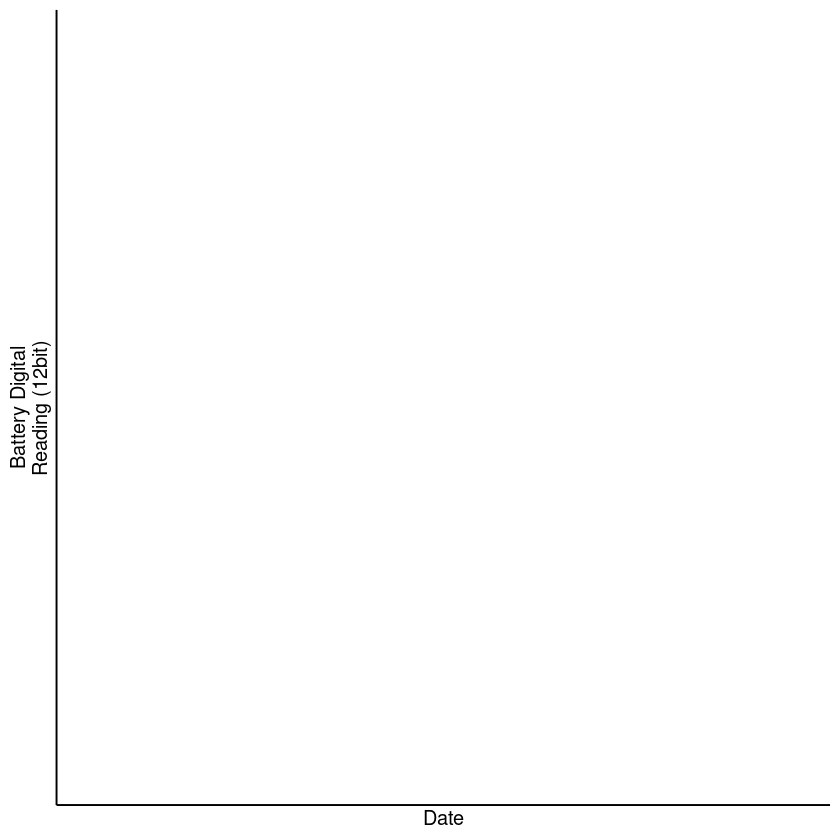

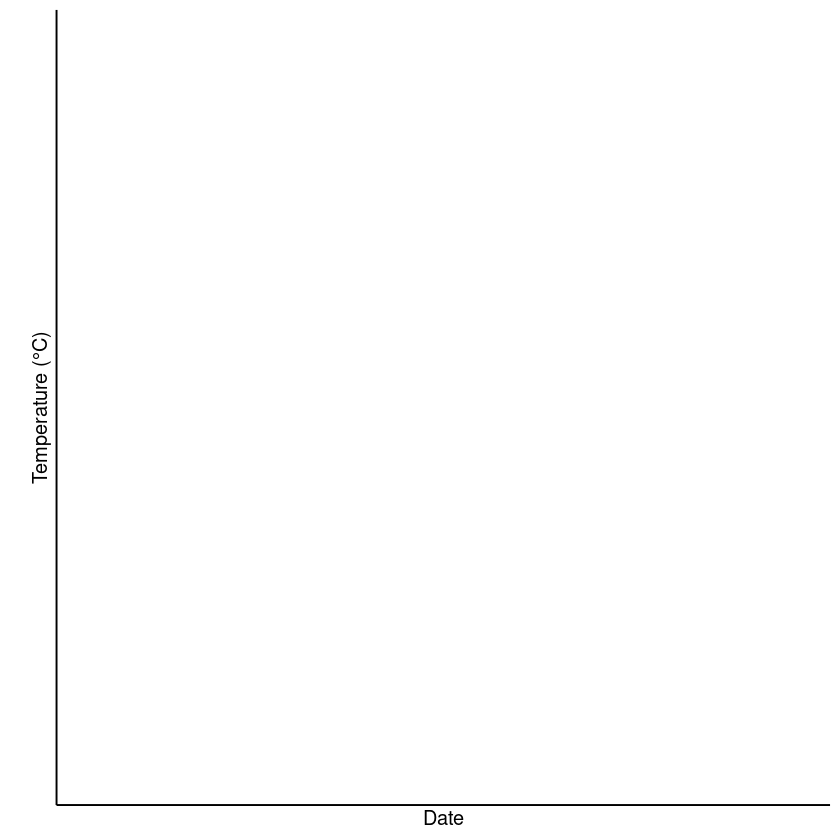

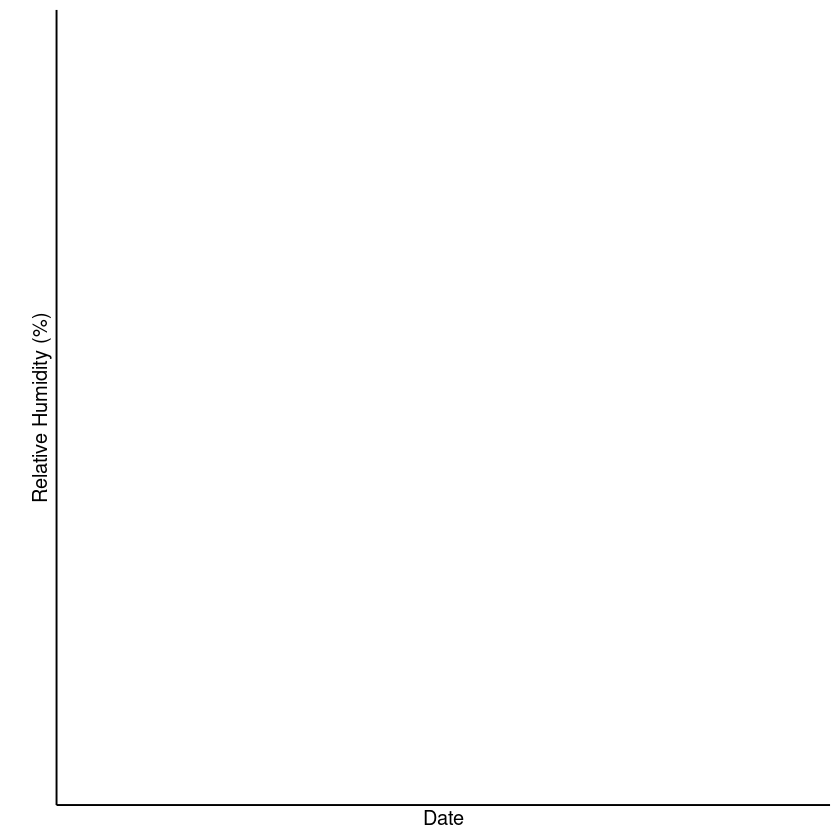

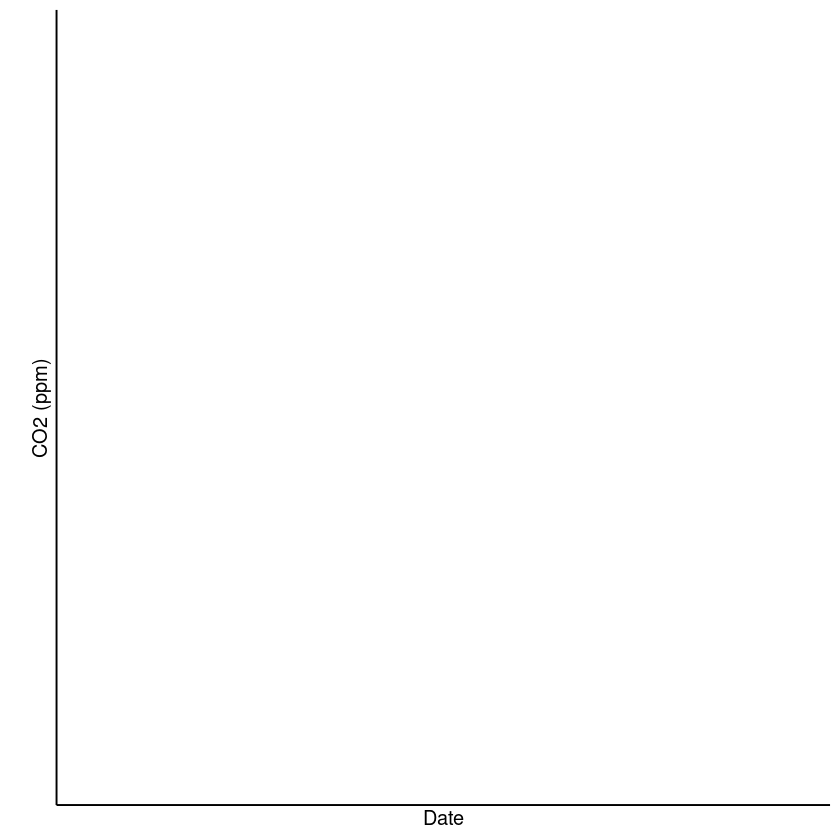

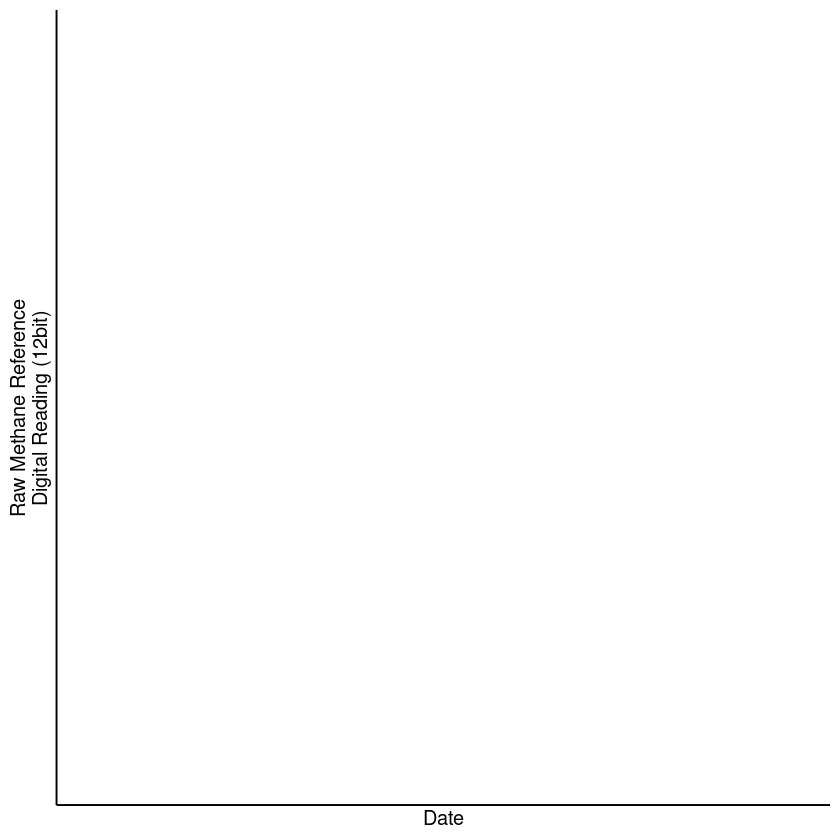

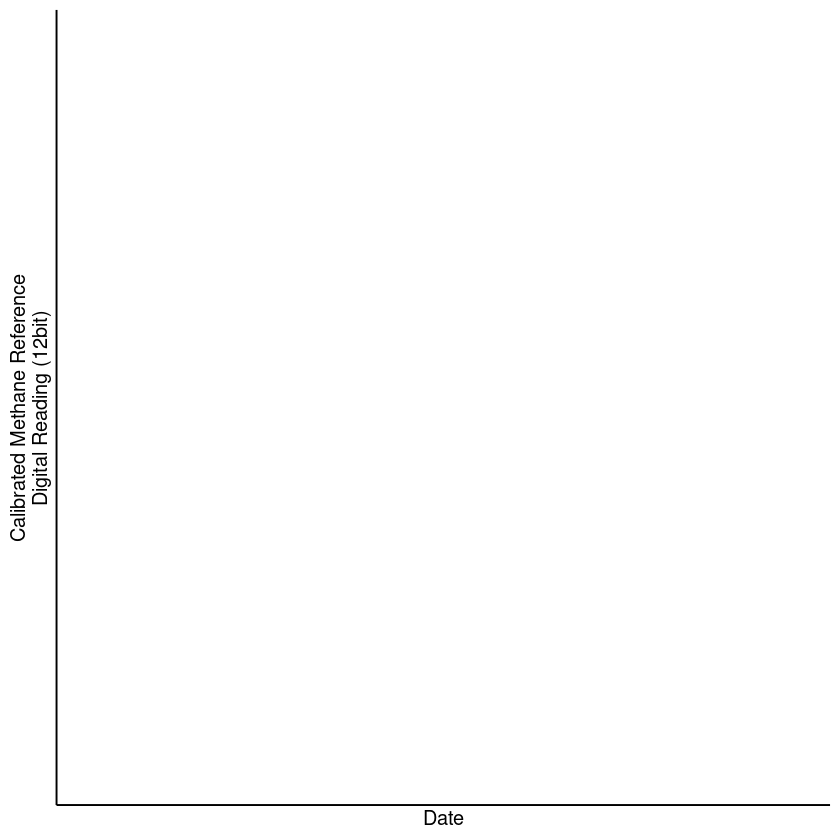

$battery.V

$dht_C

$dht_RH

$atlas_CO2_ppm

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


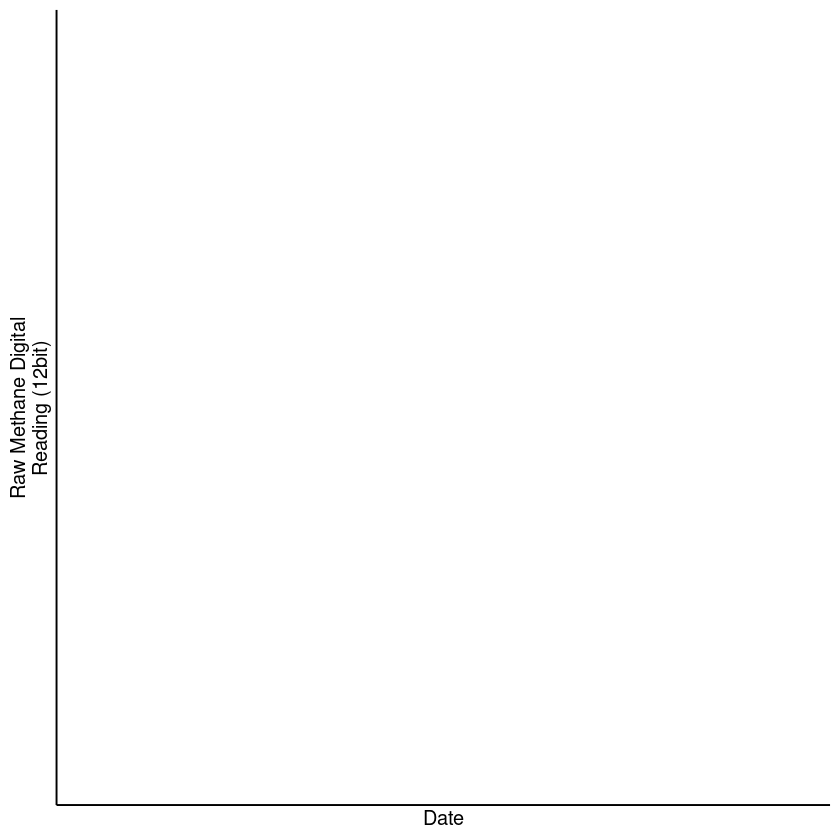

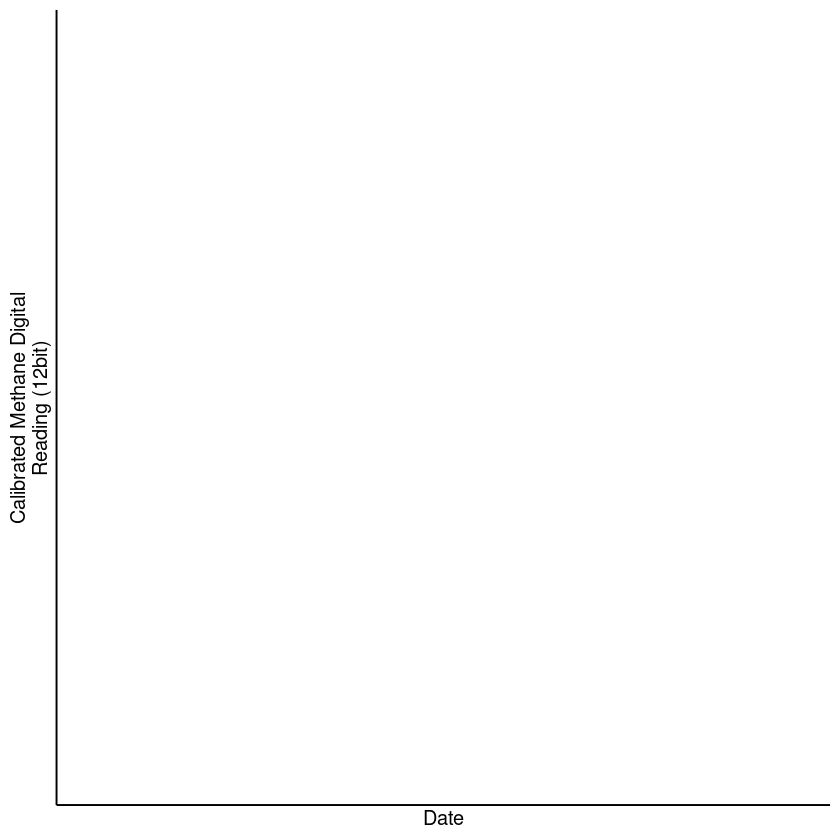

In [33]:
all_summary<-plot_Data_v_Time(summary_processed_data,color="site")
all_summary
savePlotList(all_summary,tag = "all_summary")

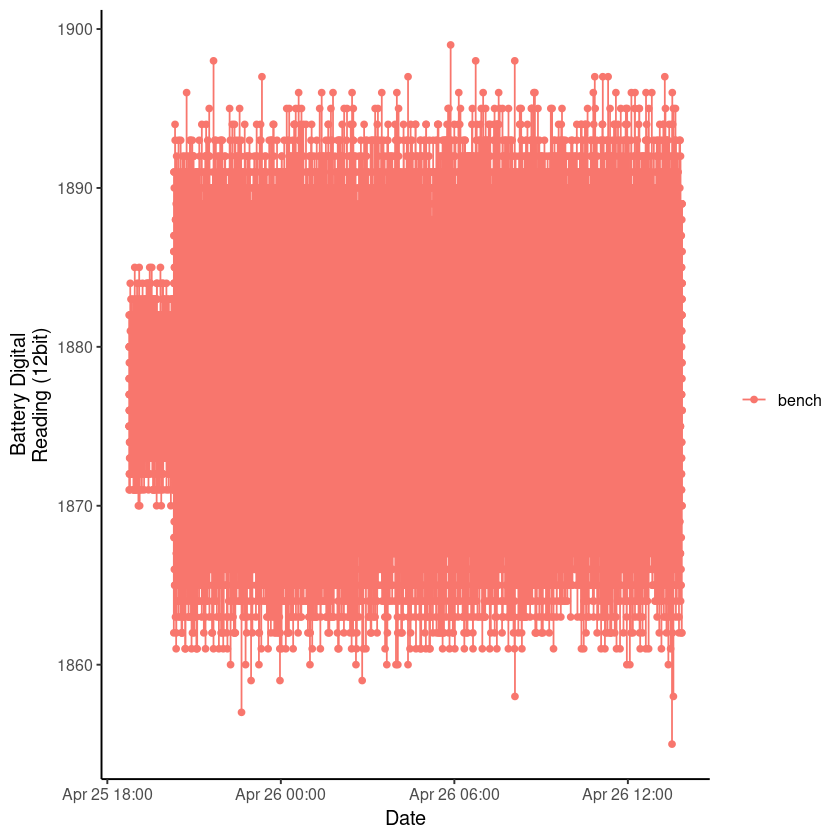

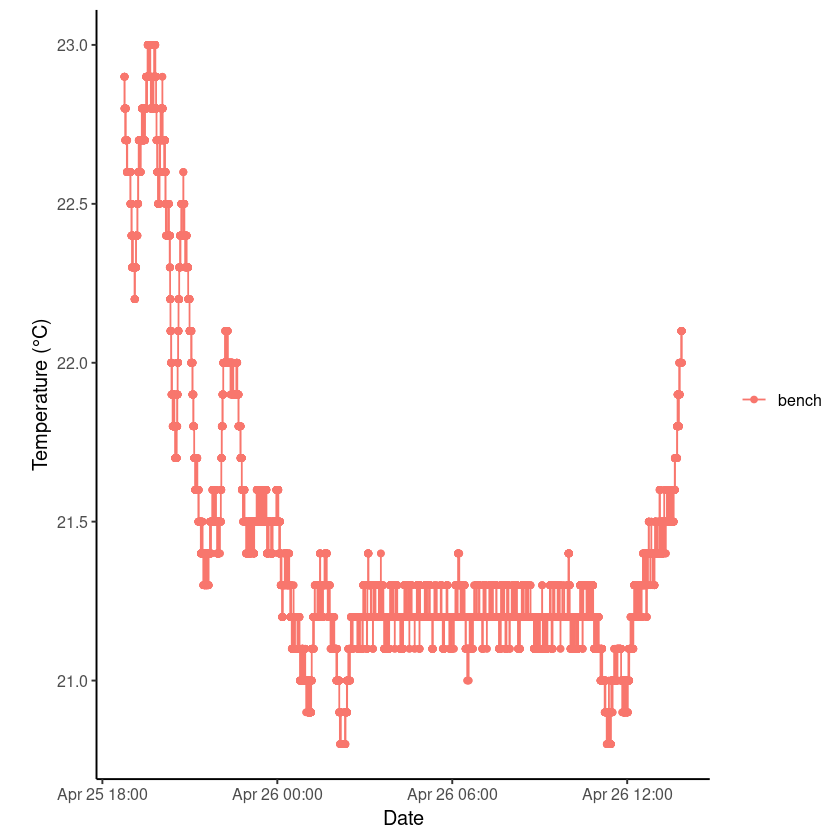

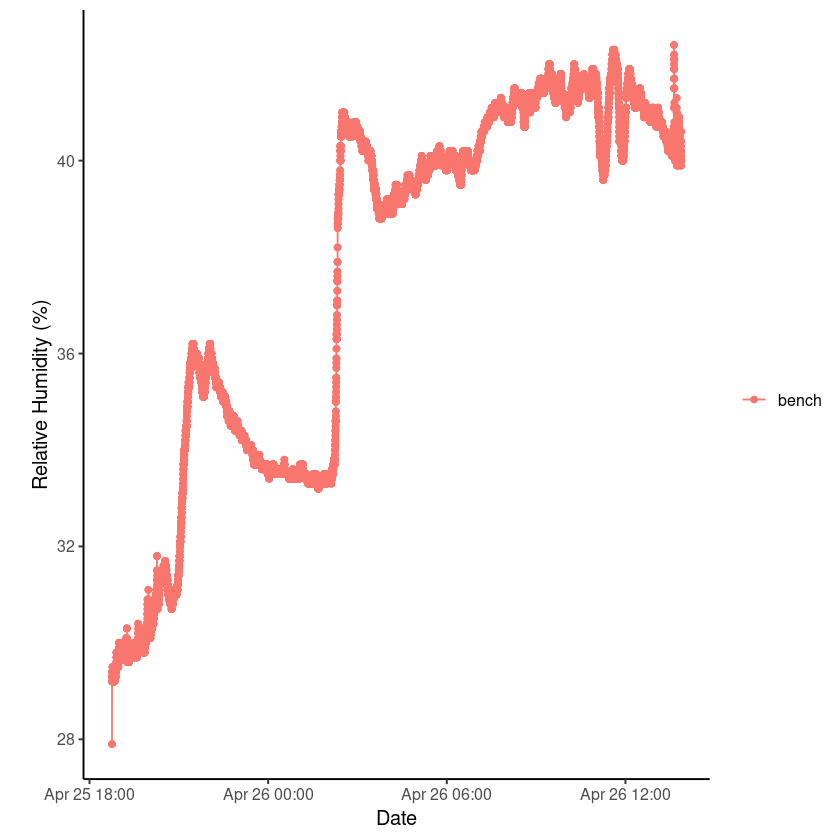

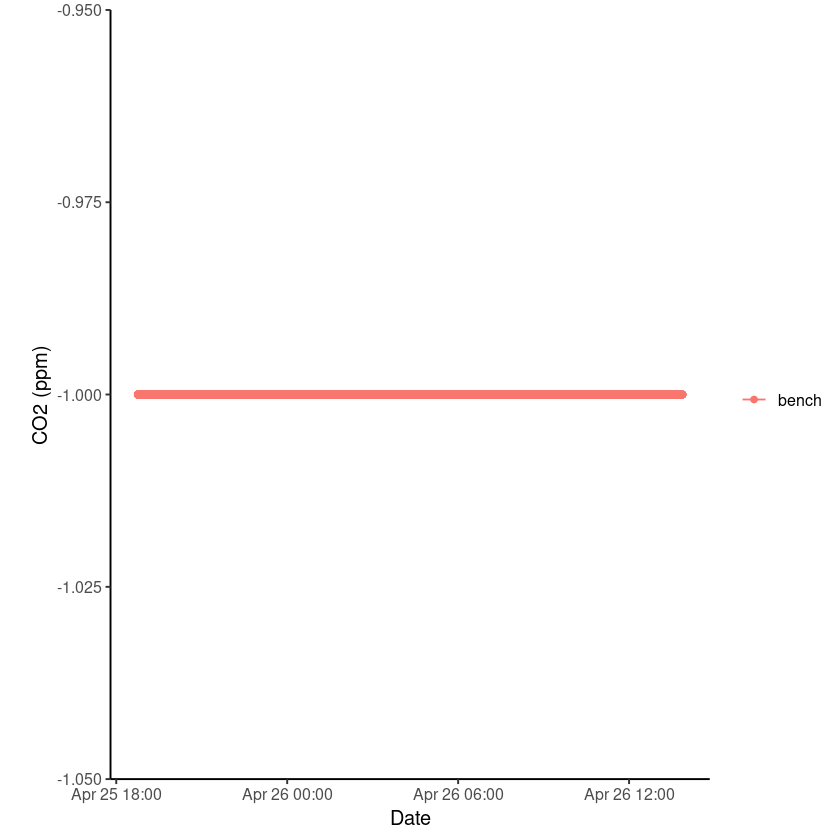

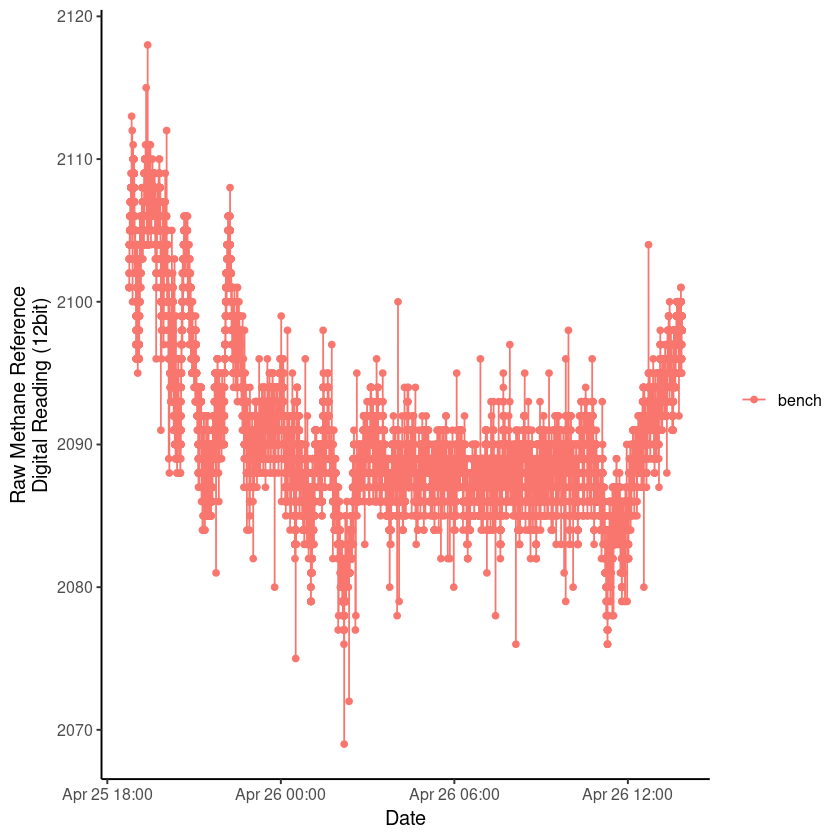

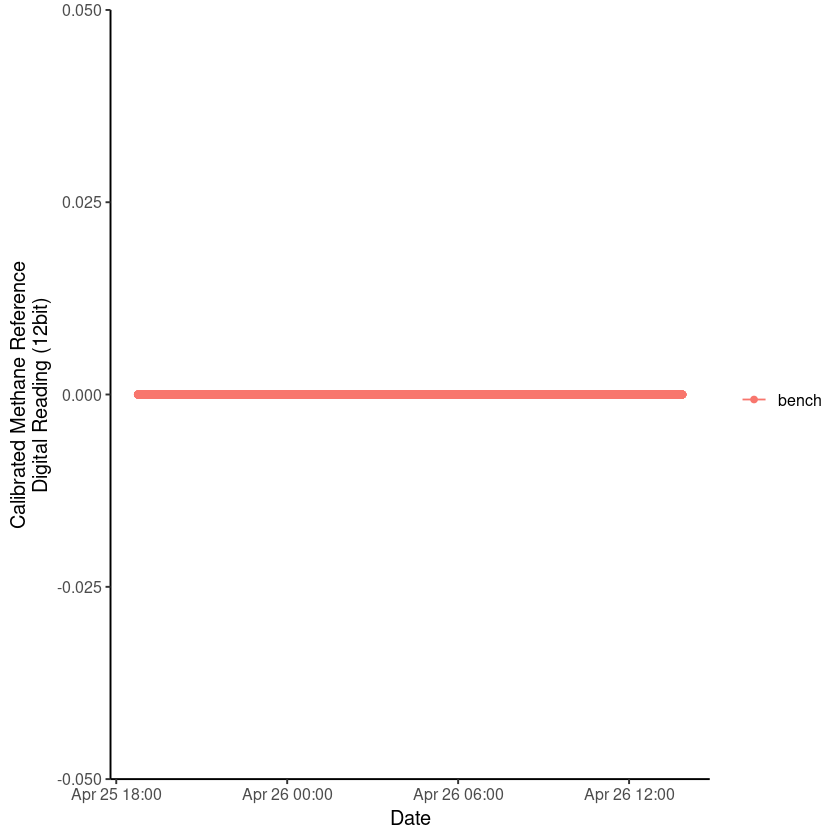

$battery.V

$dht_C

$dht_RH

$atlas_CO2_ppm

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


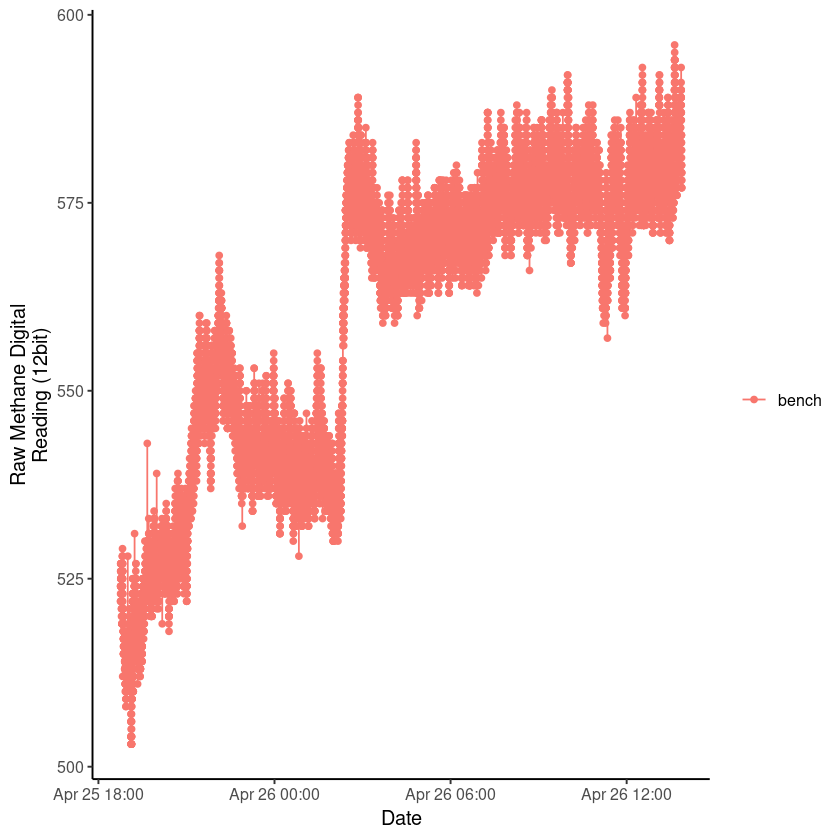

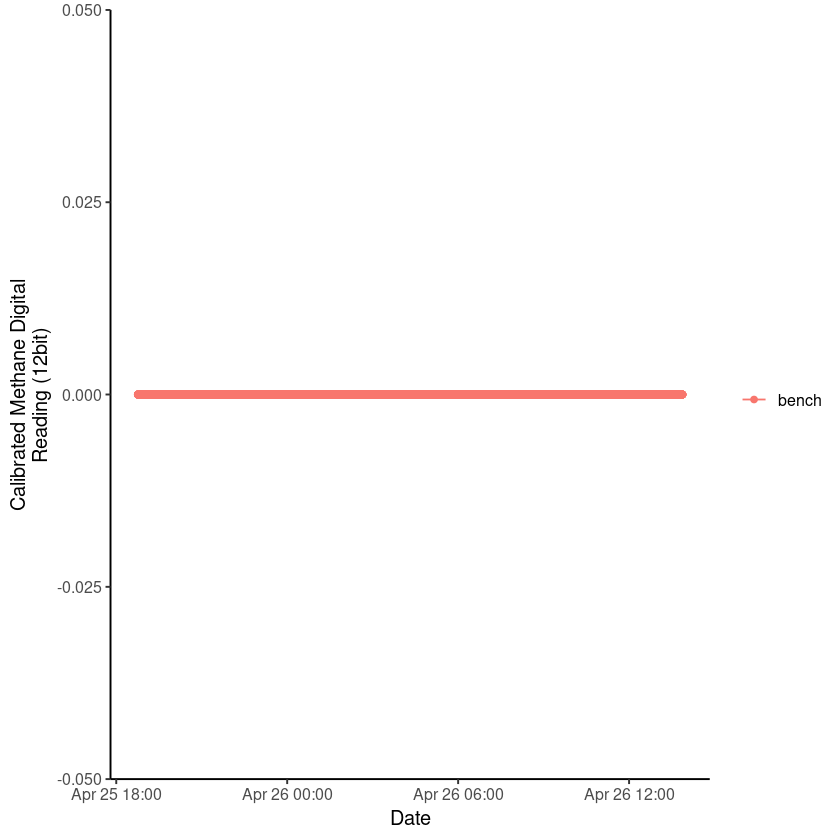

In [34]:
all_raw<-plot_Data_v_Time(raw_processed_data,color="site")
all_raw
savePlotList(all_raw, tag="all_raw")

# TODO check hourly plots function is working properly
note: color scheme changes depending on how many things are being plotted

In [30]:
hourlyPlotsvTime(summary_processed_data,id="Sensor")

Output directory not found, creating: ~/Desktop/data/codeTests/continuousPower/20230421_output/hourlyPlots/


In [35]:
hourlyPlotsvTime(raw_processed_data,id="site")

Output directory, ~/Desktop/data/codeTests/continuousPower/20230426_output/hourlyPlots/, already exists


In [219]:
# range(summary_processed_data$time.h)

In [20]:
hourlyPlotsvTimeTest<-function(df, timeCol="time.h", id="site", od=outputDir){
    oneHour=1*60*60
    rangeStart<-round( range(df[[timeCol]])[1], units="hours" )
    rangeEnd<-round( range(df[[timeCol]])[2], units ="hours")
    
    # check if od ends with /, add if not
    if(substr(od, nchar(od), nchar(od)) != "/"){ od<-paste0(od,"/") }
    
    # create output directory for hourly plots
#     h_od = paste0(od, "hourlyPlots/")
#     newDir(h_od)

    hour = 1
    while(rangeStart < rangeEnd){
        subsetEnd<-rangeStart+oneHour
        
        print(rangeStart)
        print(subsetEnd)

#         subset<-df[ df[[timeCol]]>rangeStart & df[[timeCol]]<subsetEnd ,]
#         sitePlots<-plot_Data_v_Time(subset, id)

#         savePlotList(sitePlots, tag=hour, od=h_od)

        rangeStart=rangeStart+oneHour
        
        print("")
        hour=hour+1
    }
}
hourlyPlotsvTimeTest(summary_processed_data)

[1] "2023-04-03 21:00:00 UTC"
[1] "2023-04-03 22:00:00 UTC"
[1] ""
[1] "2023-04-03 22:00:00 UTC"
[1] "2023-04-03 23:00:00 UTC"
[1] ""
[1] "2023-04-03 23:00:00 UTC"
[1] "2023-04-04 UTC"
[1] ""
[1] "2023-04-04 UTC"
[1] "2023-04-04 01:00:00 UTC"
[1] ""
[1] "2023-04-04 01:00:00 UTC"
[1] "2023-04-04 02:00:00 UTC"
[1] ""
[1] "2023-04-04 02:00:00 UTC"
[1] "2023-04-04 03:00:00 UTC"
[1] ""
[1] "2023-04-04 03:00:00 UTC"
[1] "2023-04-04 04:00:00 UTC"
[1] ""
[1] "2023-04-04 04:00:00 UTC"
[1] "2023-04-04 05:00:00 UTC"
[1] ""
[1] "2023-04-04 05:00:00 UTC"
[1] "2023-04-04 06:00:00 UTC"
[1] ""
[1] "2023-04-04 06:00:00 UTC"
[1] "2023-04-04 07:00:00 UTC"
[1] ""
[1] "2023-04-04 07:00:00 UTC"
[1] "2023-04-04 08:00:00 UTC"
[1] ""
[1] "2023-04-04 08:00:00 UTC"
[1] "2023-04-04 09:00:00 UTC"
[1] ""
[1] "2023-04-04 09:00:00 UTC"
[1] "2023-04-04 10:00:00 UTC"
[1] ""
[1] "2023-04-04 10:00:00 UTC"
[1] "2023-04-04 11:00:00 UTC"
[1] ""
[1] "2023-04-04 11:00:00 UTC"
[1] "2023-04-04 12:00:00 UTC"
[1] ""
[1] "2023-04-

In [220]:
# hourlyPlotsvTime<-function(df, timeCol="time.h"){
#     oneHour=1*60*60
#     rangeStart<-round( range(df[[timeCol]])[1], units="hours" )
#     rangeEnd<-round( range(df[[timeCol]])[2], units ="hours")

#     h_od = paste(sep="", outputDir,"hourlyPlots/")
#     newDir(h_od)

#     hour = 1
#     while(rangeStart < rangeEnd){
#         subsetEnd<-rangeStart+oneHour

#         subset<-df[ df[[timeCol]]>rangeStart & df[[timeCol]]<subsetEnd ,]
#         sitePlots<-plot_Data_v_Time(subset, "site")

#         savePlotList(sitePlots, tag=paste(sep="",hour,"_"), od=h_od)

#         rangeStart=rangeStart+oneHour
#         hour=hour+1
#     }
# }

#create and save hourly plots of variables vs time into a new folder
hourlyPlotsvTime(summary_processed_data, id = "Sensor")

Output directory not found, creating: ~/Desktop/data/Methane Calibration/field_test/20230317_deployment/RRIV_output/hourlyPlots/


In [37]:
# create output directory for individual plots containing all UUIDs

# check if od ends with /, add if not
od=outputDir
if(substr(od, nchar(od), nchar(od)) != "/"){ od<-paste0(od,"/") }

individual_od = paste0(od, "individualPlots/")
newDir(individual_od)

Output directory not found, creating: ~/Desktop/data/Methane Calibration/field_test/20230411_deployment/RRIV_output/individualPlots/


In [222]:
individualPLL_summary<-plot_individual_logger_data_v_time(df = summary_processed_data,idCol = "Sensor")

In [223]:
savePlotListList(individualPLL_summary,tag = "ip",od = individual_od)

In [38]:
individualPLL_raw<-plot_individual_logger_data_v_time(df = raw_processed_data,idCol = "Sensor")
savePlotListList(individualPLL_raw,tag = "ip_raw",od = individual_od)

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_point).”
Warning message:
“Removed 13081 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_point).”
Warning message:
“Removed 13081 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


# todo: rewrite these two functions
1. add a function to save each variable v time plot into its own folder

In [ ]:
# create list of hourly plots of each metric from dataframe, save them as pngs and return list
hourlyPlotList <- function(df, cols_plots, ylabs){
  col_L = length(cols_plots)
  
  # initialize empty list of lists to hold plots
  hPL <- vector('list', col_L)
  names(hPL) = cols_plots
  hours <- sort(unique(df[['datehour']]))
  for(i in 1:col_L){
    ## in case a column does not have the same amount of unique hours of data as another
    # colData <- data.frame(df[cols_plots[i]], df['datehour'])
    # hours <- unique(colData[['datehour']])
    hPL[[ cols_plots[i] ]] <- vector('list', length(hours))
    names( hPL[[ cols_plots[i] ]] ) = hours
  }
  
  # loop through and plot each hour of data for each metric
  for(i in 1:col_L){
    ## in case a column does not have the same amount of unique hours of data as another
    # colData <- data.frame(df[cols_plots[i]], df['datehour'])
    # hours <- unique(colData[['datehour']])
    for(j in 1:length(hours)){
      #subset, create plot, and store in list
      hourSubset <- df[df$datehour == hours[j] ,]
      hPL[[ cols_plots[i] ]][[ hours[j] ]] = ggplot(data=hourSubset,aes_string(x="datetime",y=cols_plots[i],color="logger",shape="site"))+
        geom_point(size=2)+geom_line(size=1)+theme_classic(base_size=18)+
        labs(x="Time (hr:min)", y=ylabs[i], color="Logger")+
        scale_color_manual(values=custom_colors,na.translate=F)+
        scale_x_datetime(date_labels="%H:%M",breaks=scales::pretty_breaks(n=4),expand=c(0,60*1.5))
      # expand is adding 60 sec * 1.5 to each side of the scale [the base unit for datetime?]
    }
  }
  return(hPL)
}

# input a list of lists of hourly plots per metric
# output ggarrange and save a png containing each hourly plot for each metric
saveArrHourlyPlotsPerMetric <- function(hourlyPlots, cols_plots, outputDir, filePrefix=""){
  n = round(sqrt(length(hourlyPlots[[ cols_plots[1] ]])))
  sqPixels = n * 800

  # loop through and ggarrange each metric
  for(i in 1:length(cols_plots)){
    cat(sprintf("ggarrange and save: %s\n", cols_plots[i]))
    toSave <- ggarrange(ncol=n, nrow=n, plotlist=hourlyPlots[[ cols_plots[i] ]], common.legend=TRUE)
    pngPath = paste(sep="",outputDir,filePrefix,cols_plots[i],".png")

    png(file=pngPath,width=sqPixels,height=sqPixels)
    print(toSave)
    dev.off()
  }
}

[1] "2023-03-09 18:00:00 UTC"

[1] "2023-03-09 19:00:00 UTC"

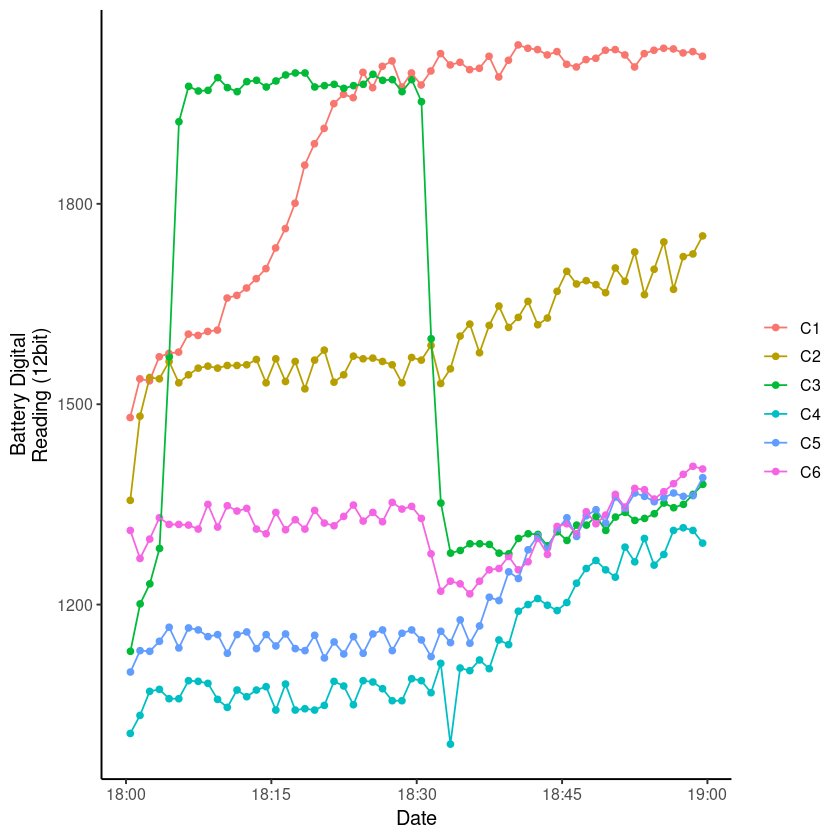

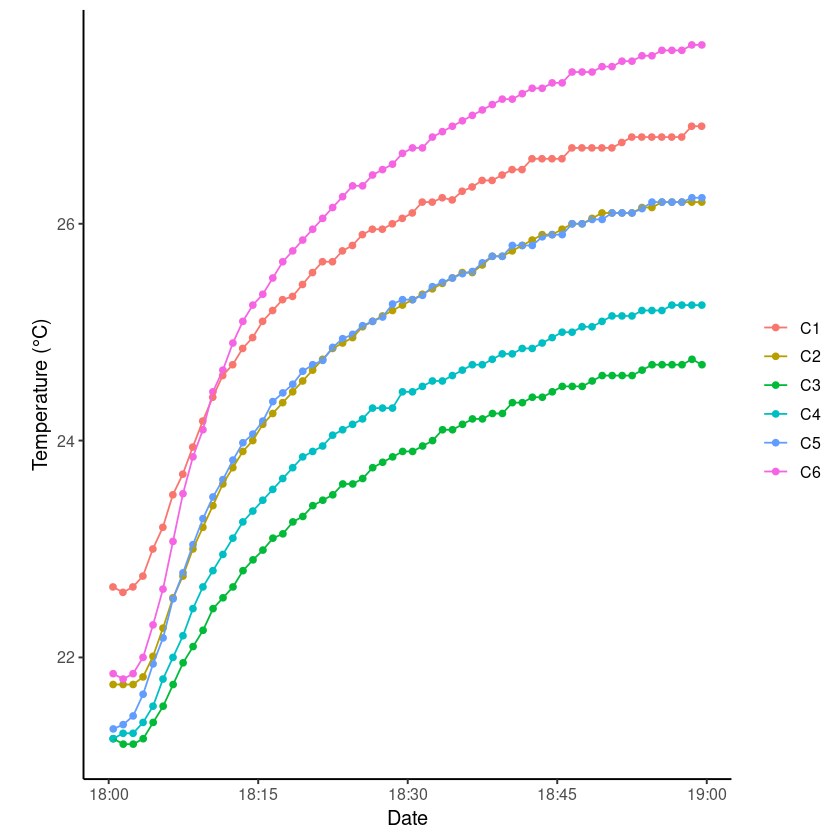

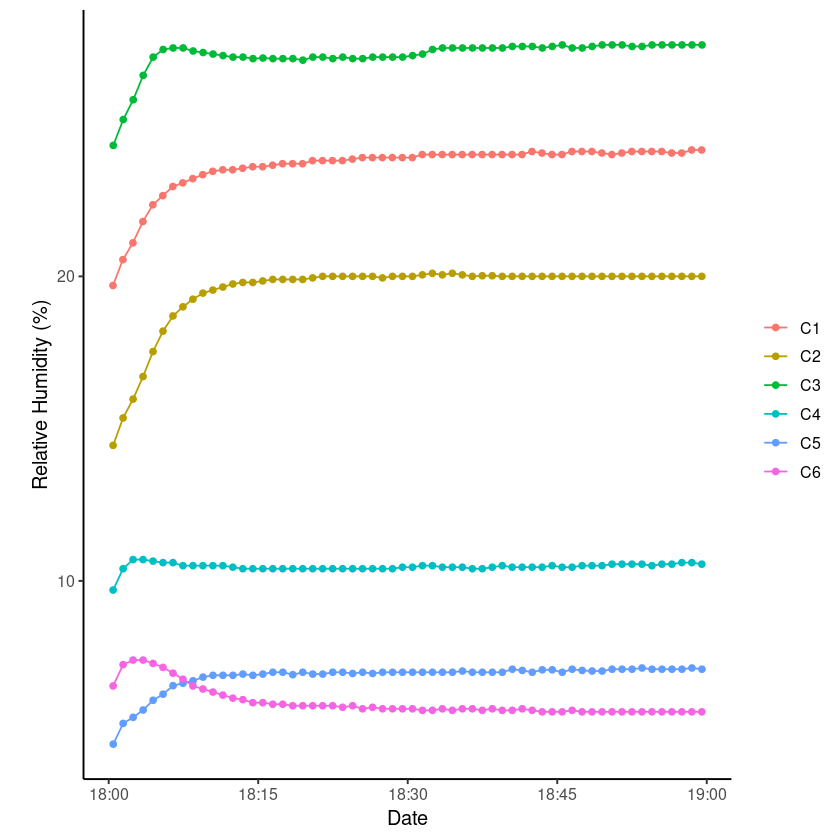

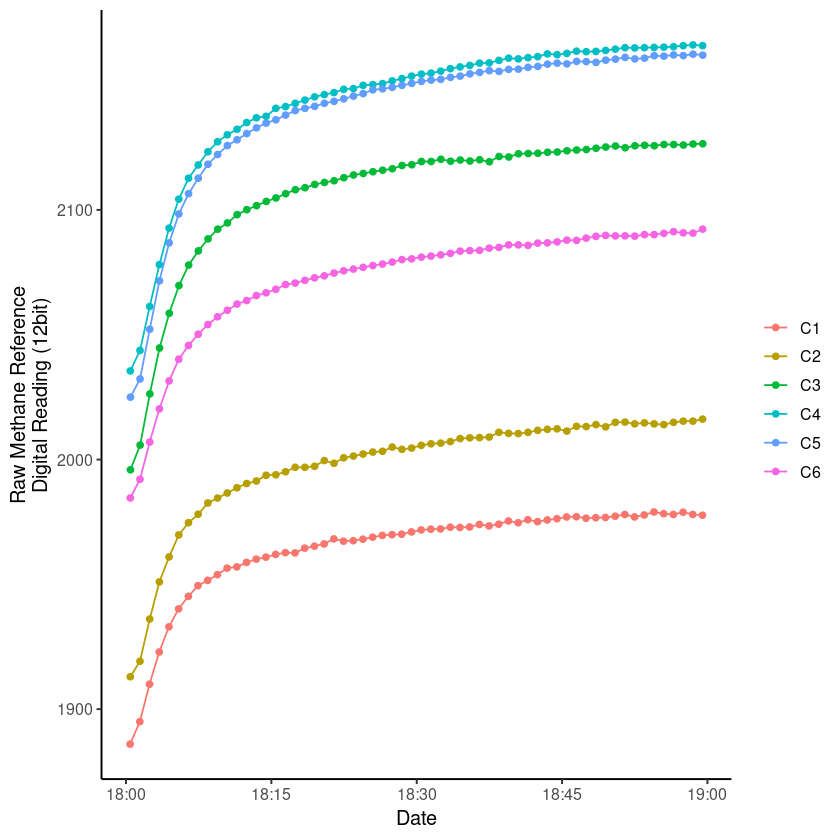

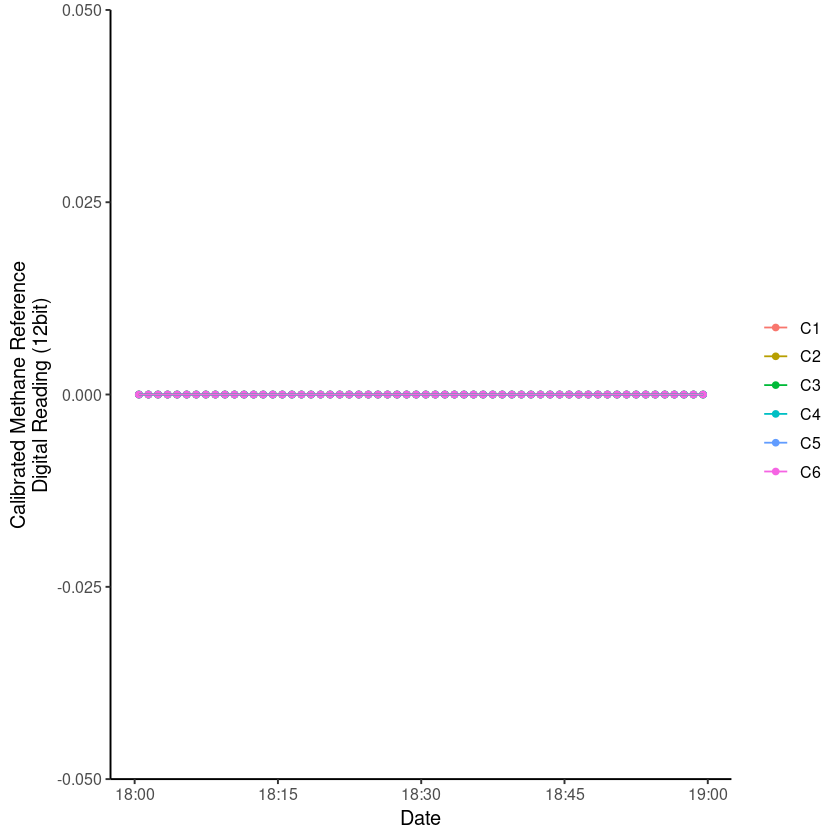

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


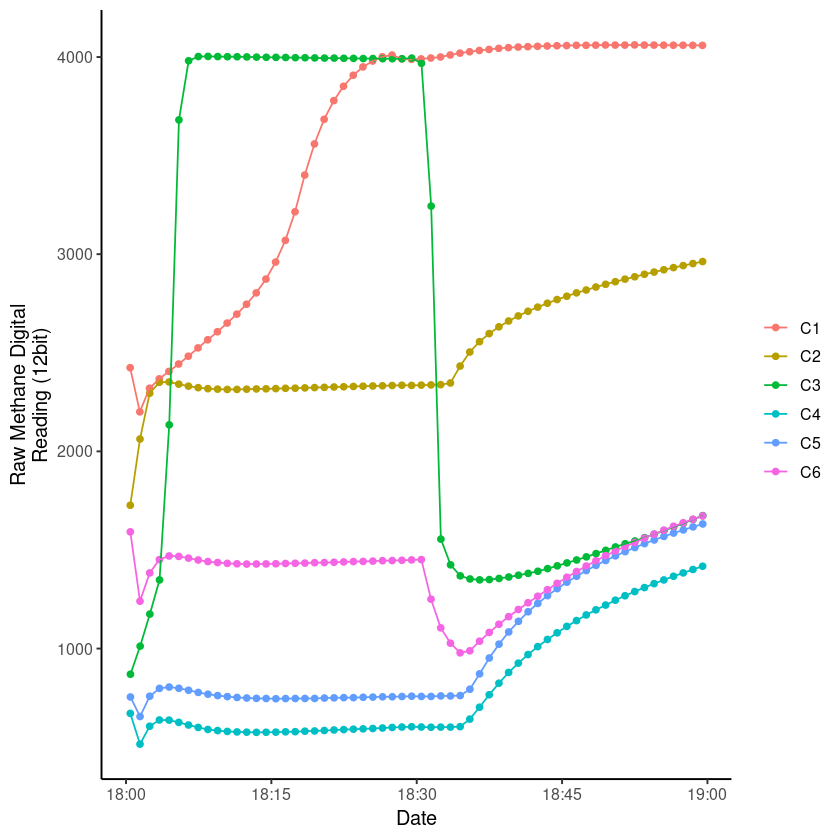

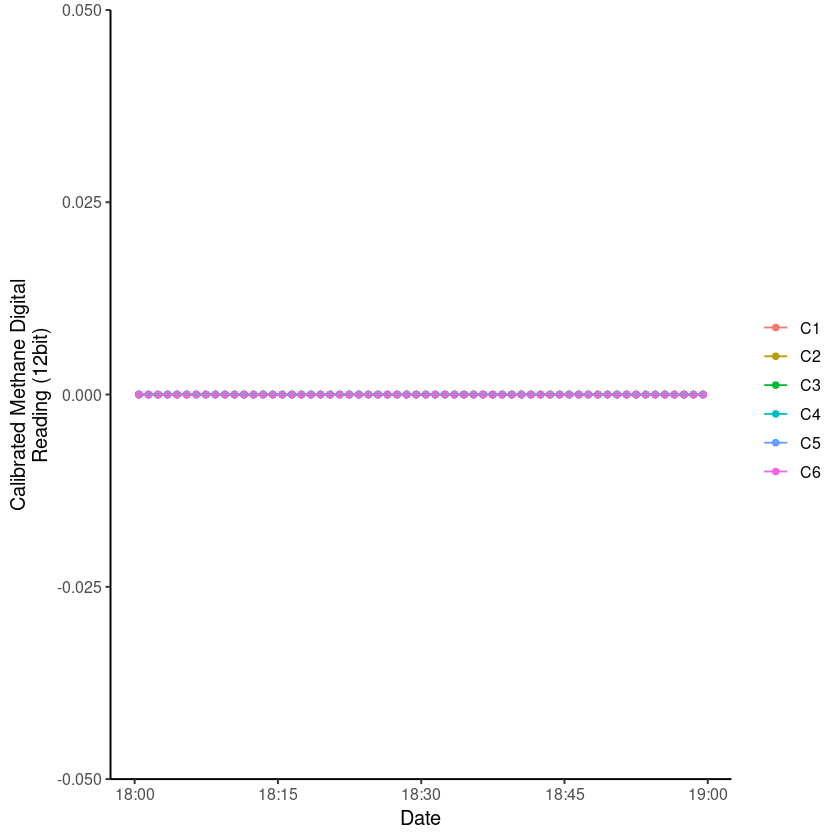

In [22]:
startTime<-lubridate::as_datetime("2023-03-09 18:06:26 UTC")
startTime <-round(startTime,units="hours")
startTime
endTime<-startTime+1*60*60
endTime

subset1<-summary_processed_data[summary_processed_data$time.h>startTime &
                             summary_processed_data$time.h<endTime ,]


loggerPlots<-plot_Data_v_Time(subset1, "site")
loggerPlots

[1] "2023-03-09 19:00:00 UTC"

[1] "2023-03-09 20:00:00 UTC"

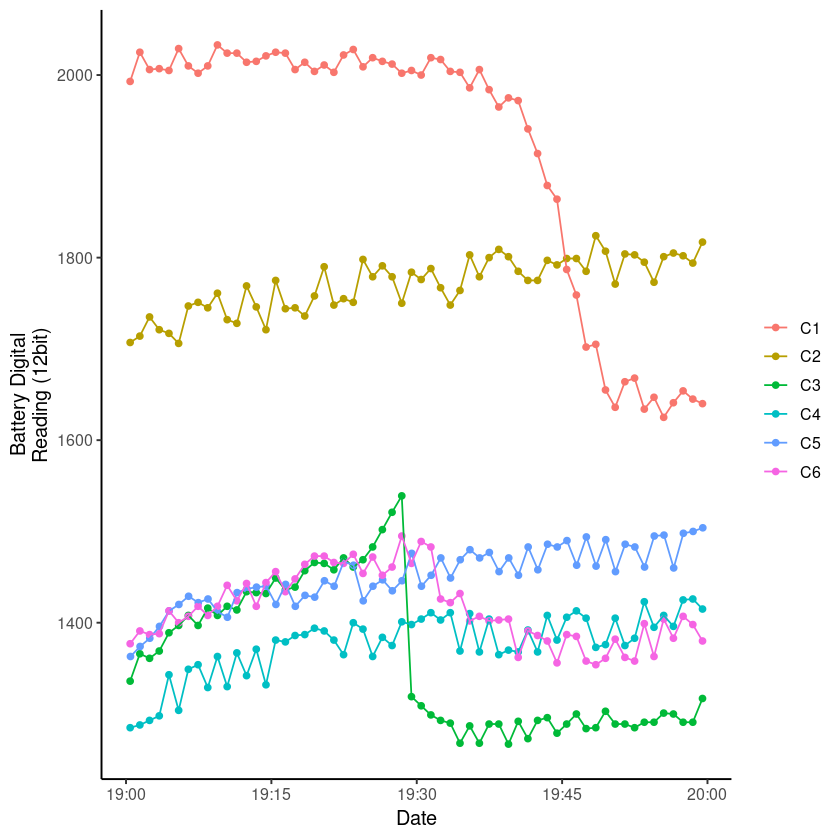

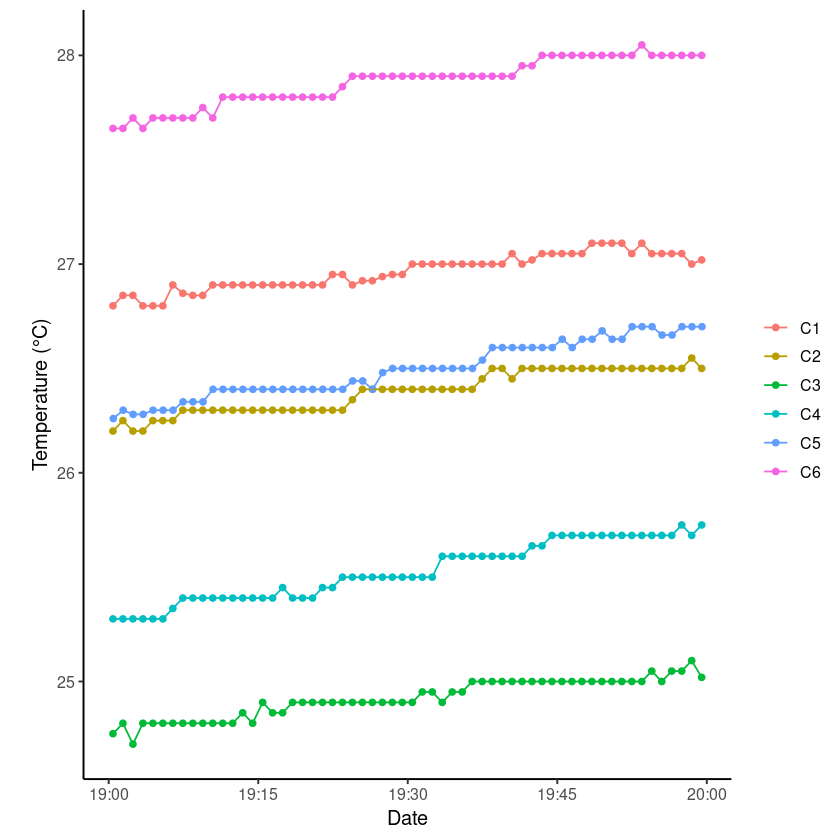

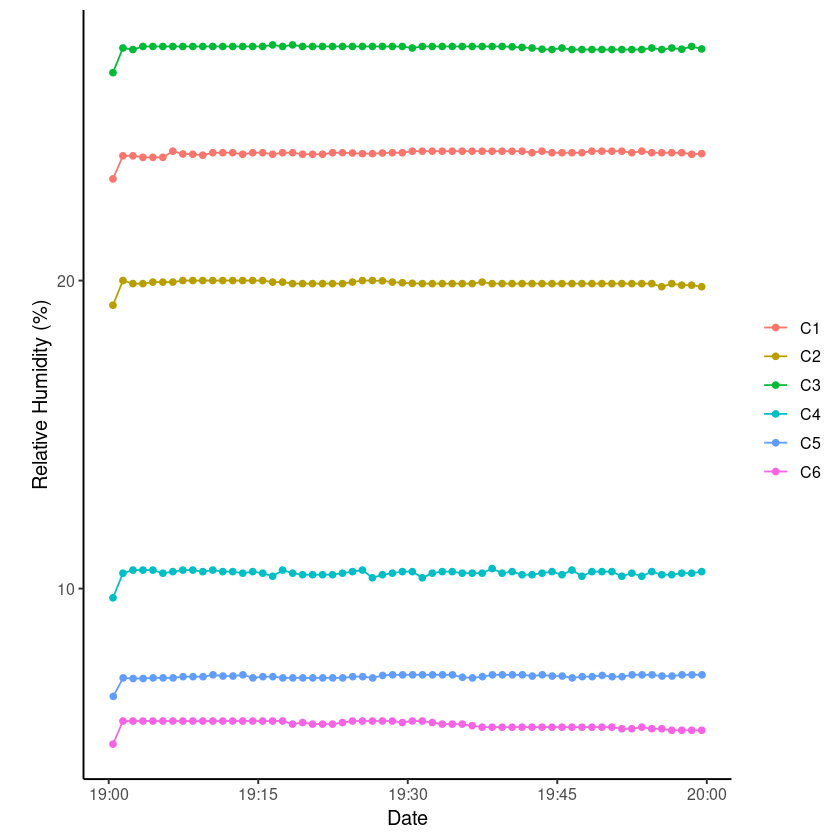

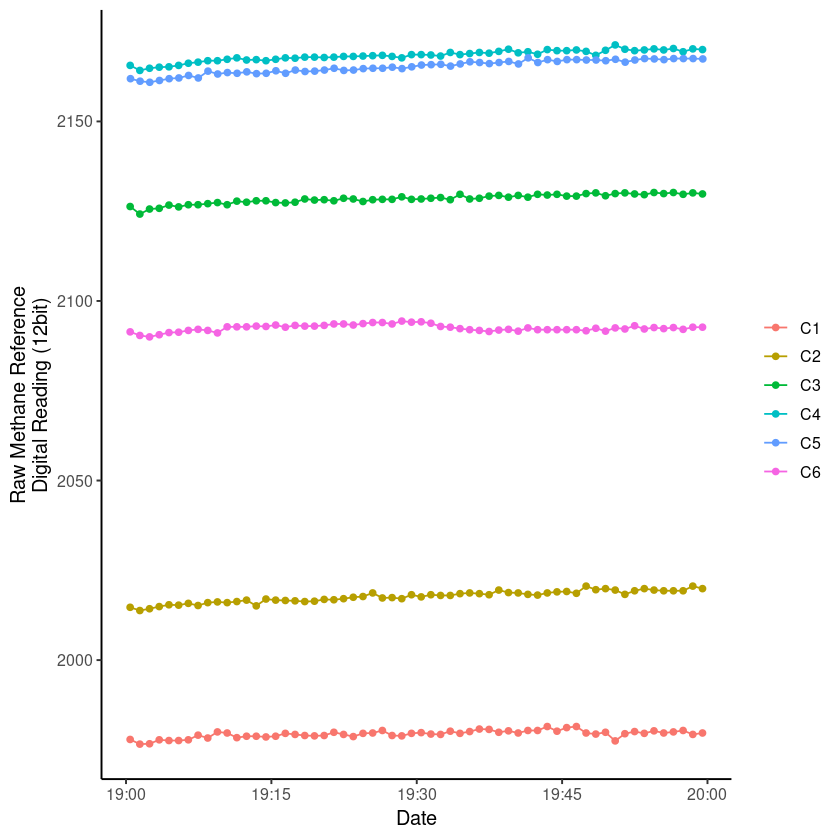

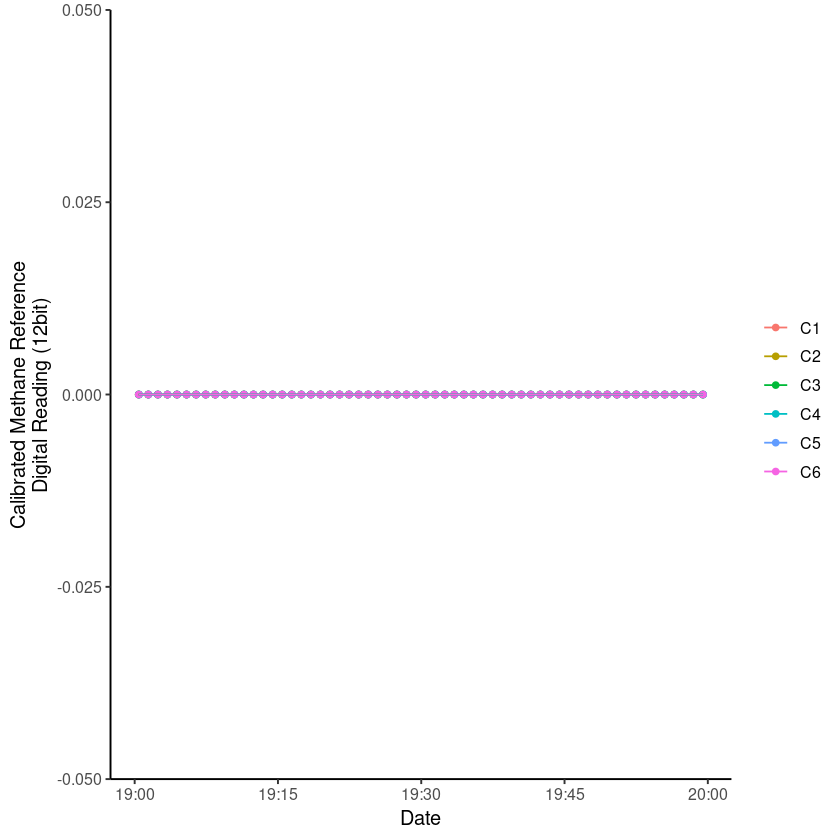

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


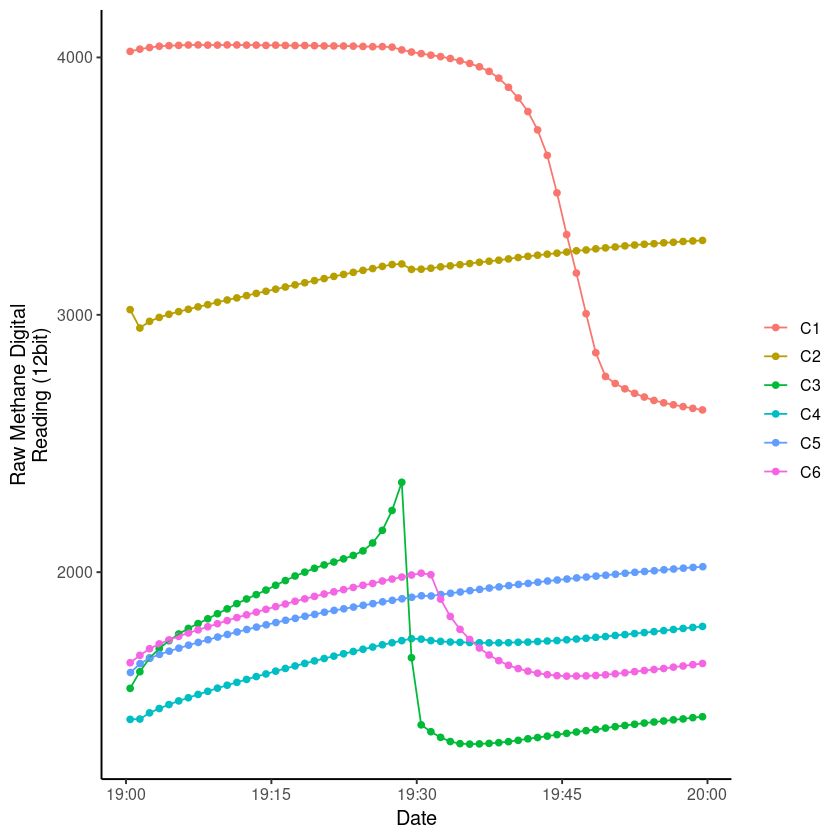

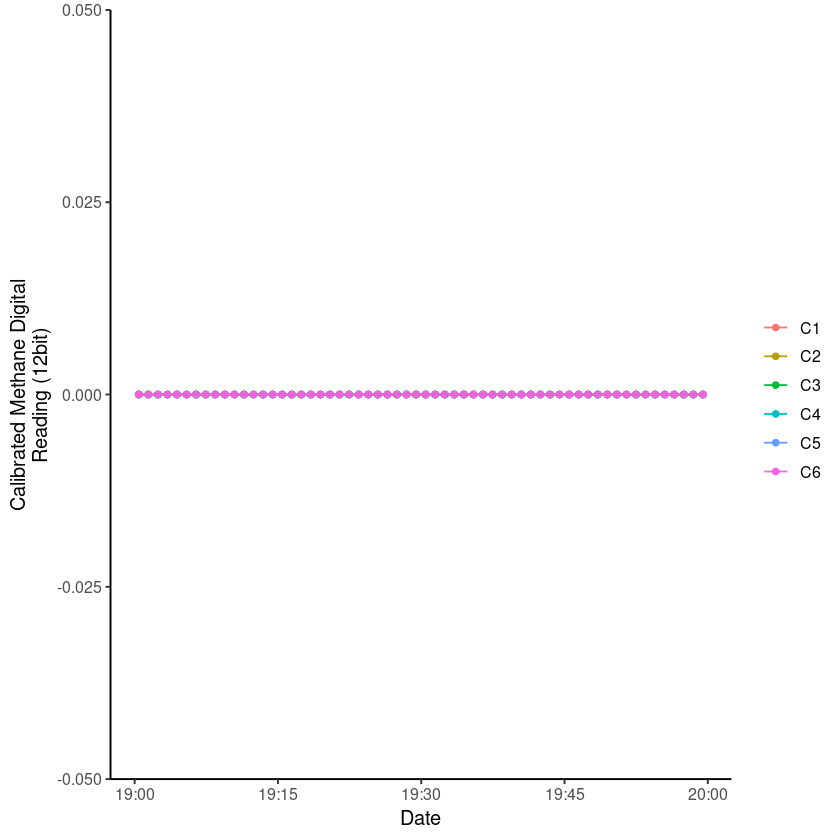

In [23]:
startTime<-endTime
endTime<-startTime+1*60*60
startTime
endTime

subset2<-summary_processed_data[summary_processed_data$time.h>startTime &
                             summary_processed_data$time.h<endTime ,]

loggerPlots<-plot_Data_v_Time(subset2, "site")
loggerPlots

[1] "2023-03-09 20:00:00 UTC"

[1] "2023-03-09 21:00:00 UTC"

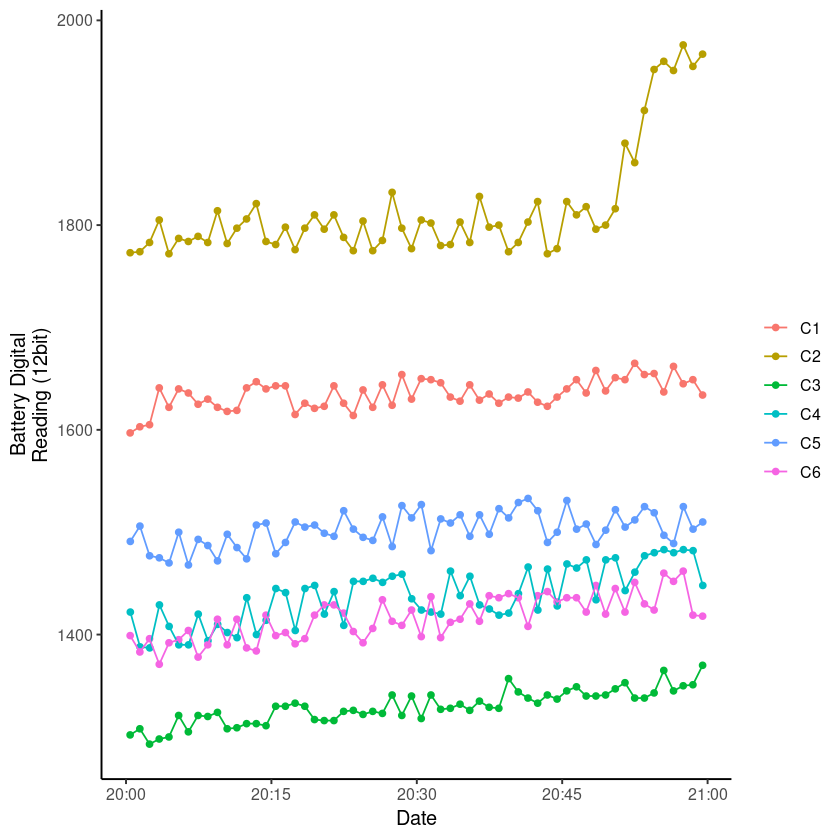

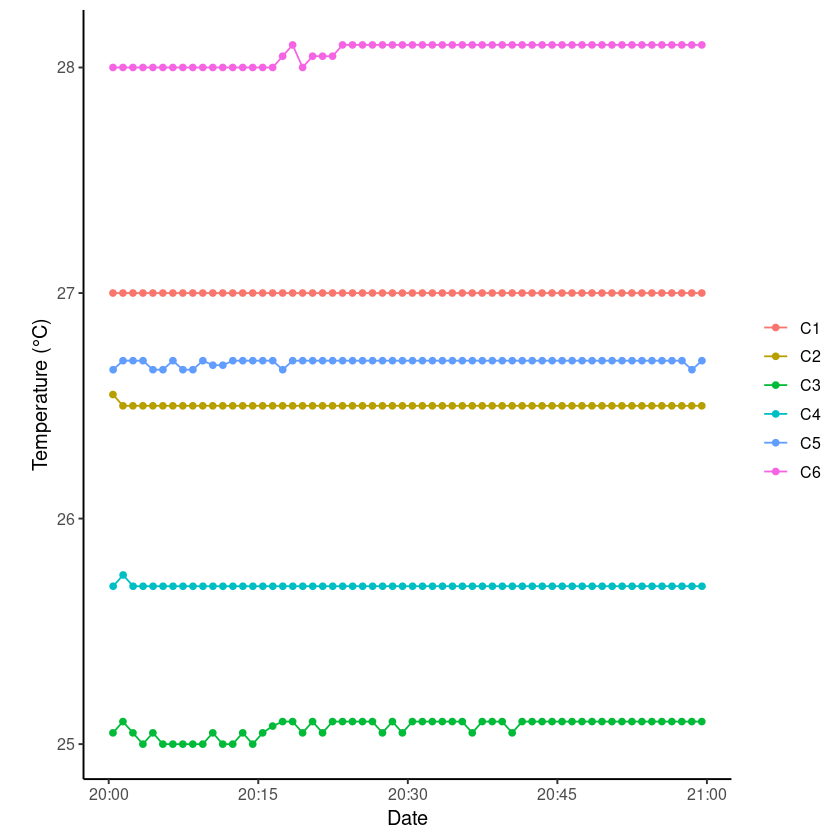

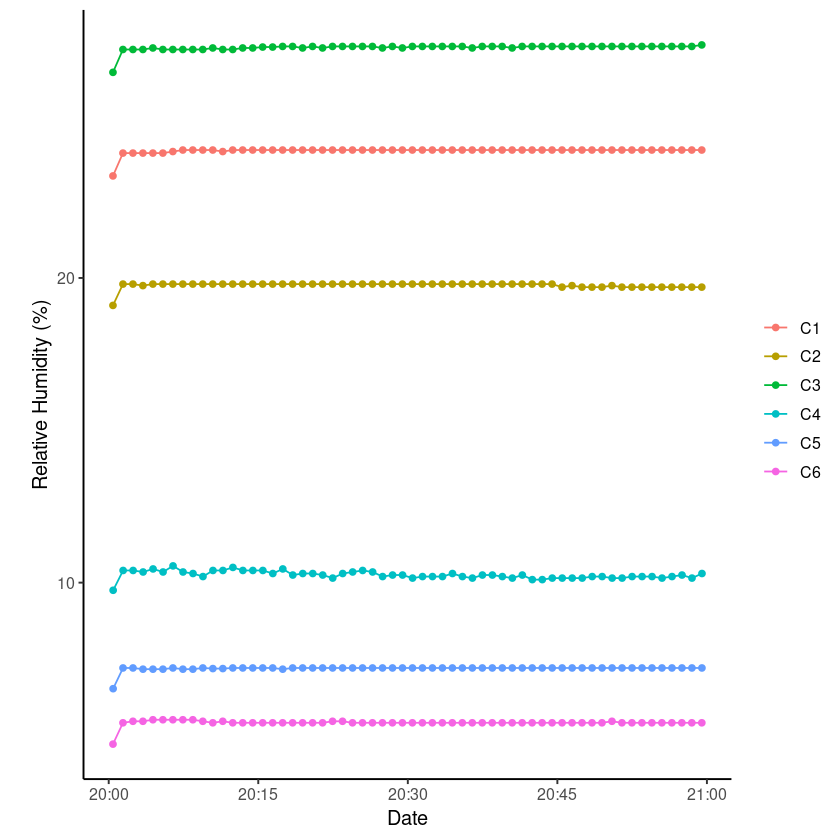

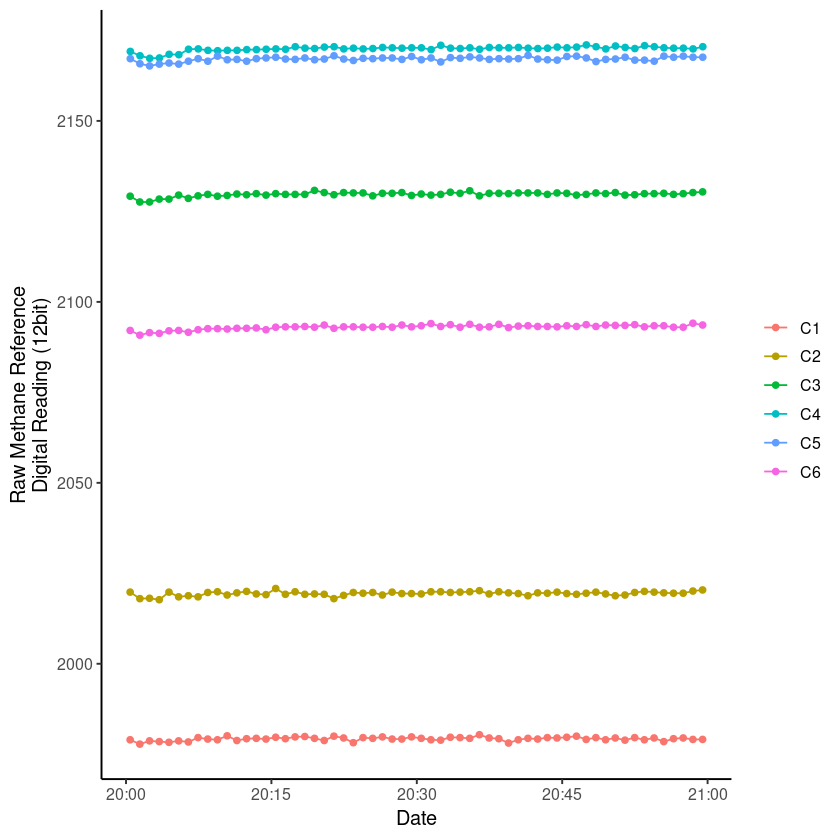

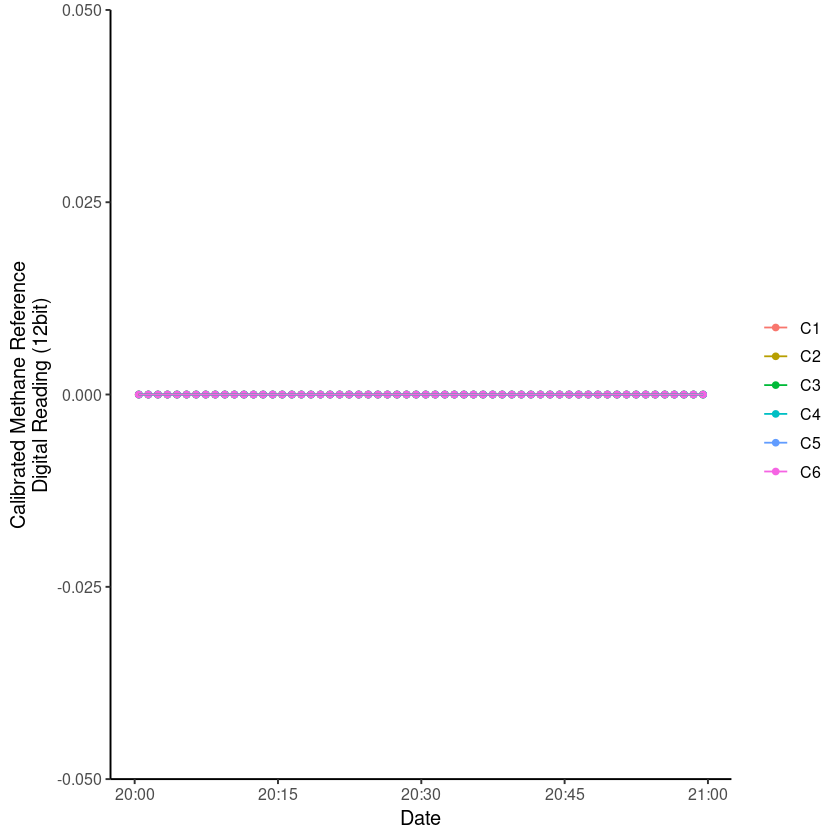

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


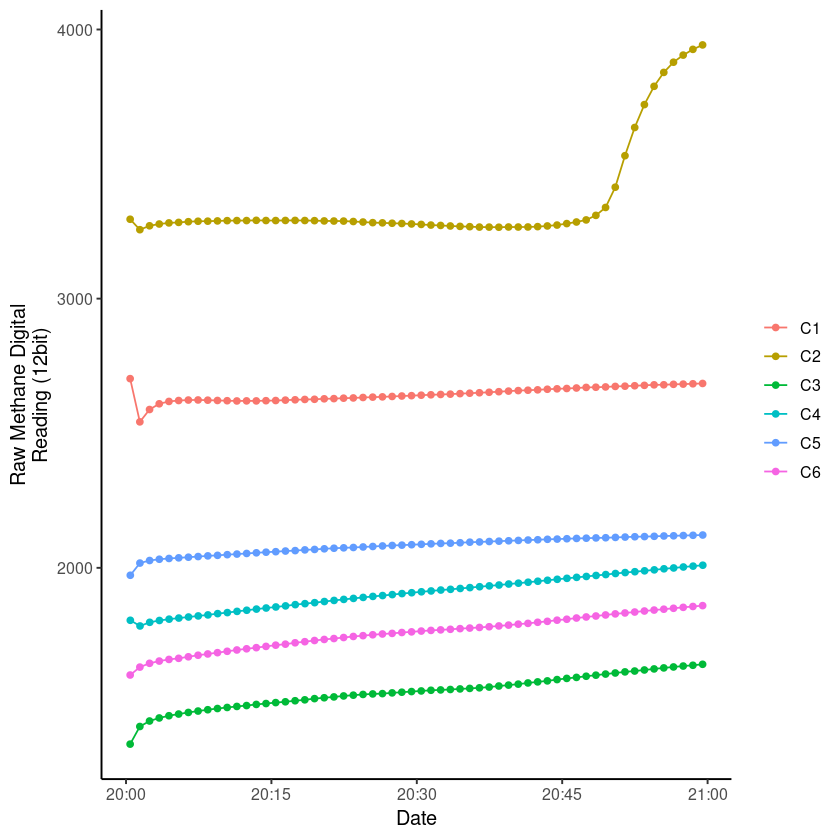

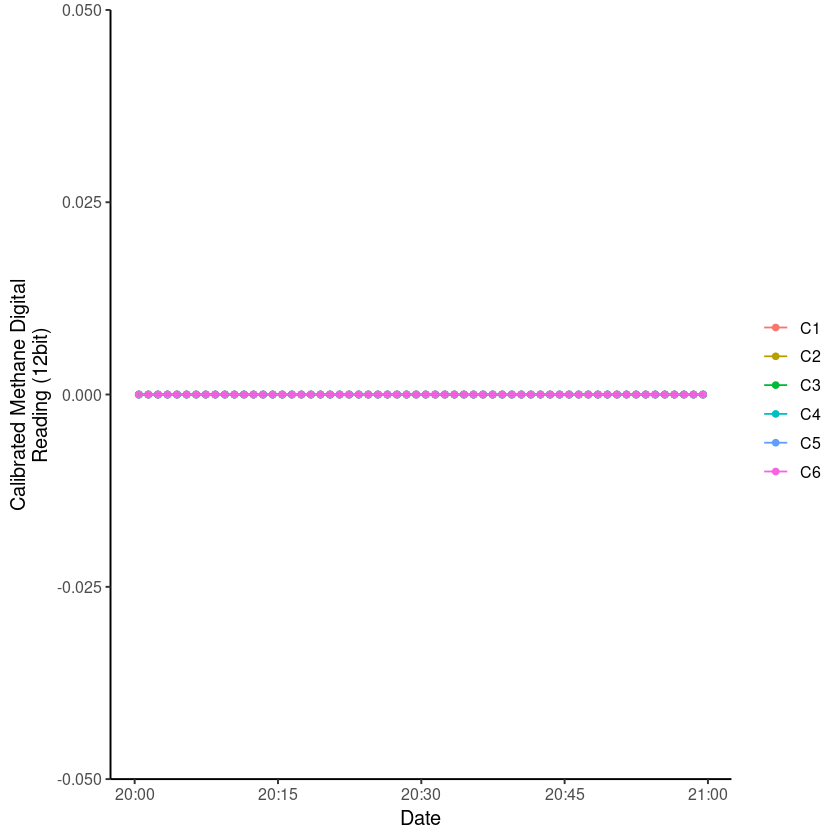

In [24]:
startTime<-endTime
endTime<-startTime+1*60*60
startTime
endTime

subset3<-summary_processed_data[summary_processed_data$time.h>startTime &
                             summary_processed_data$time.h<endTime ,]

loggerPlots<-plot_Data_v_Time(subset3, "site")
loggerPlots

In [18]:
# startTime<-lubridate::as_datetime("2023-02-27 20:00:26 UTC")
# endTime<-startTime+1*60*60

# subset_spd<-summary_processed_data[ summary_processed_data$time.h>startTime &
#                                   summary_processed_data$time.h<endTime ,]

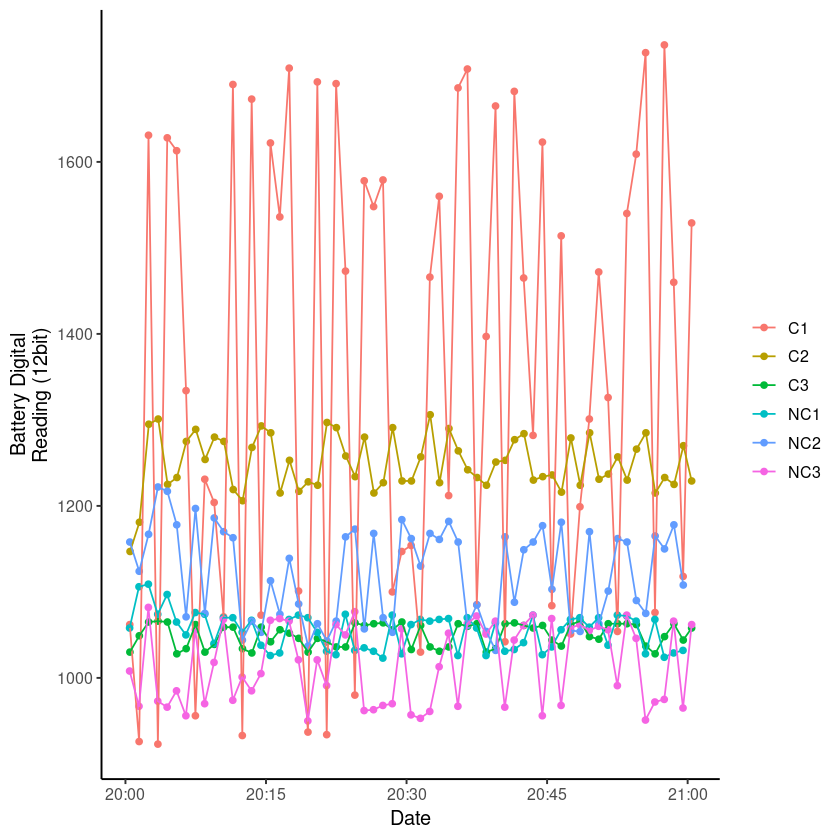

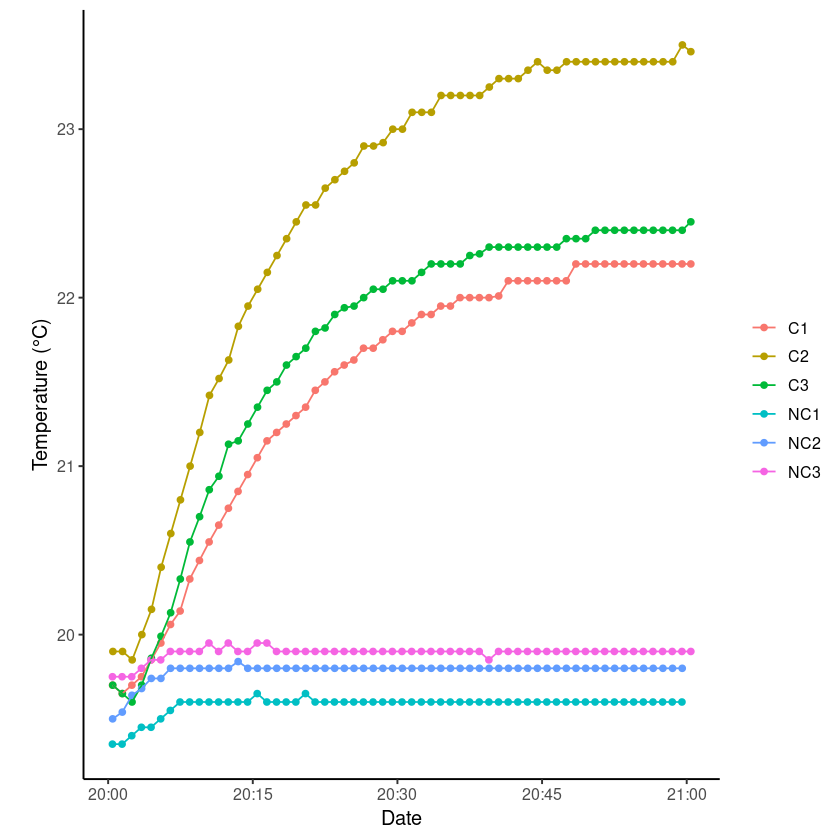

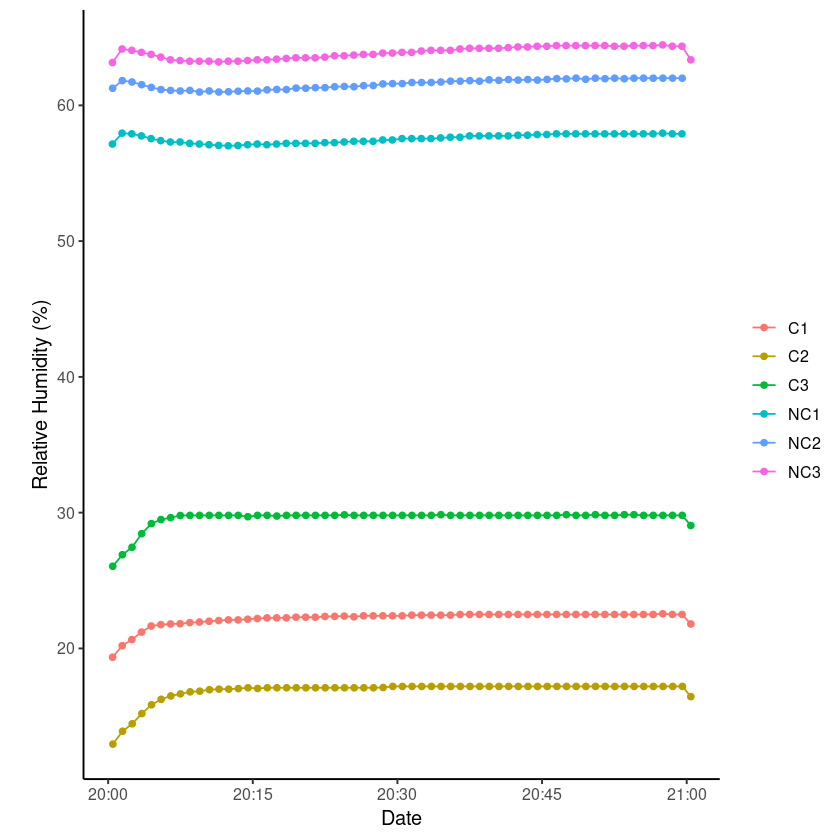

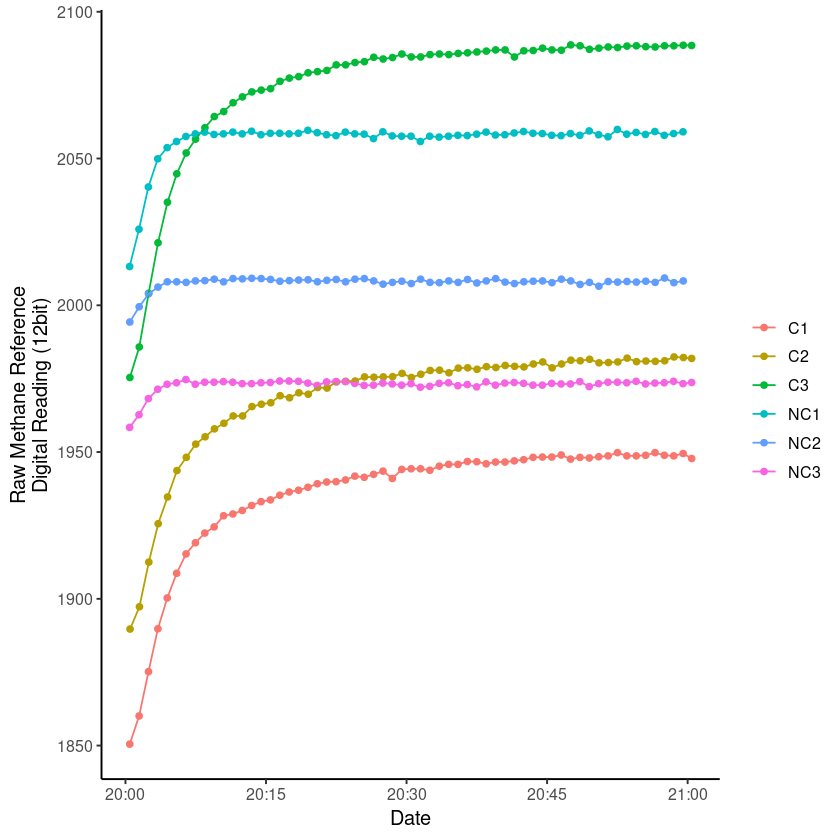

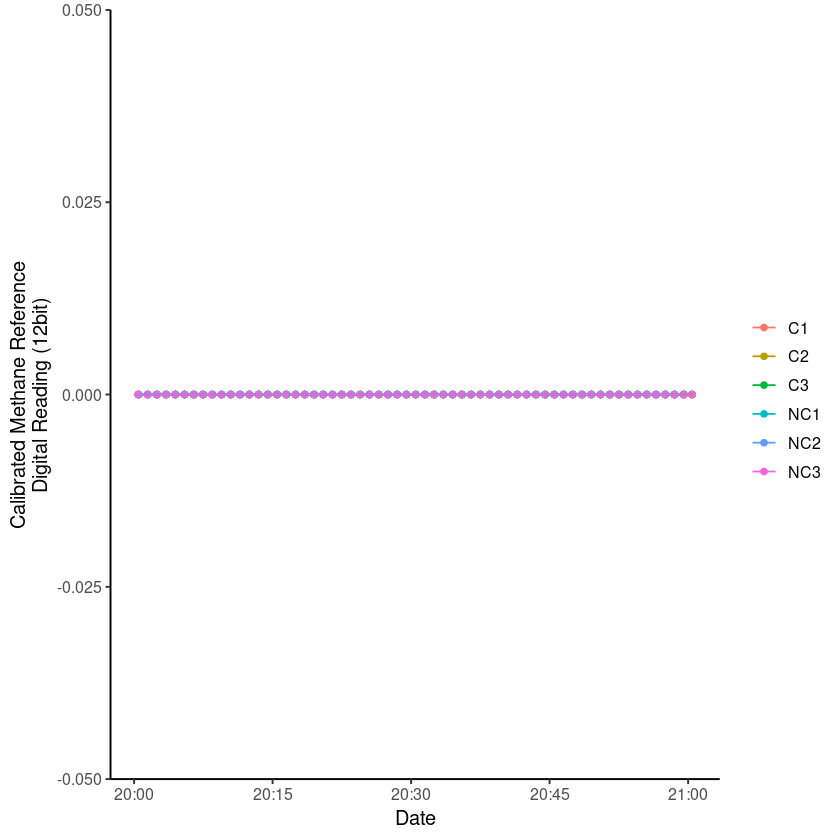

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


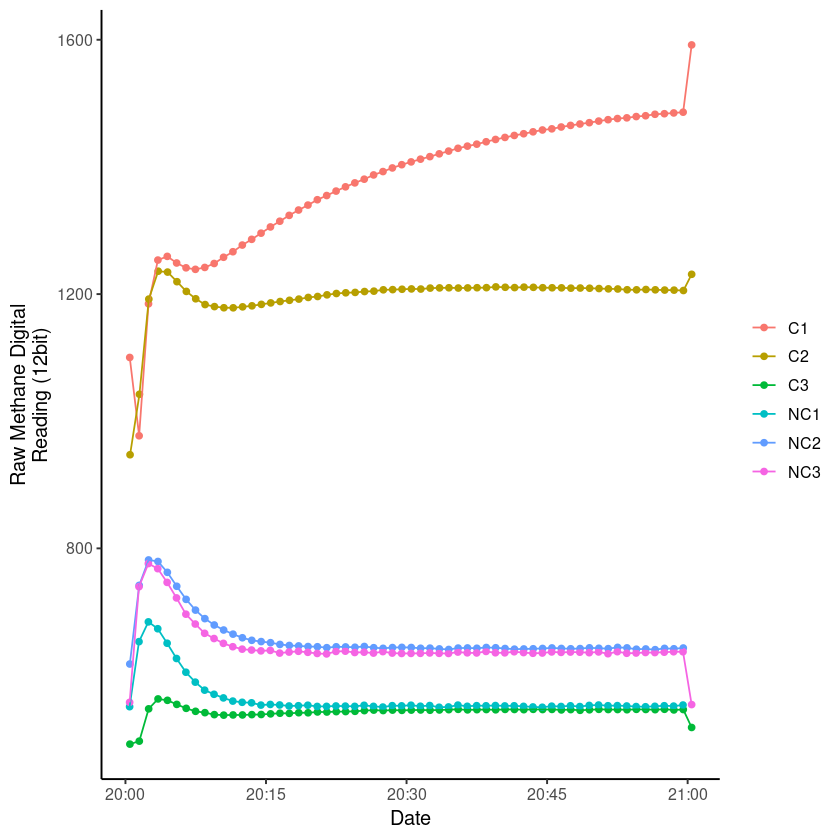

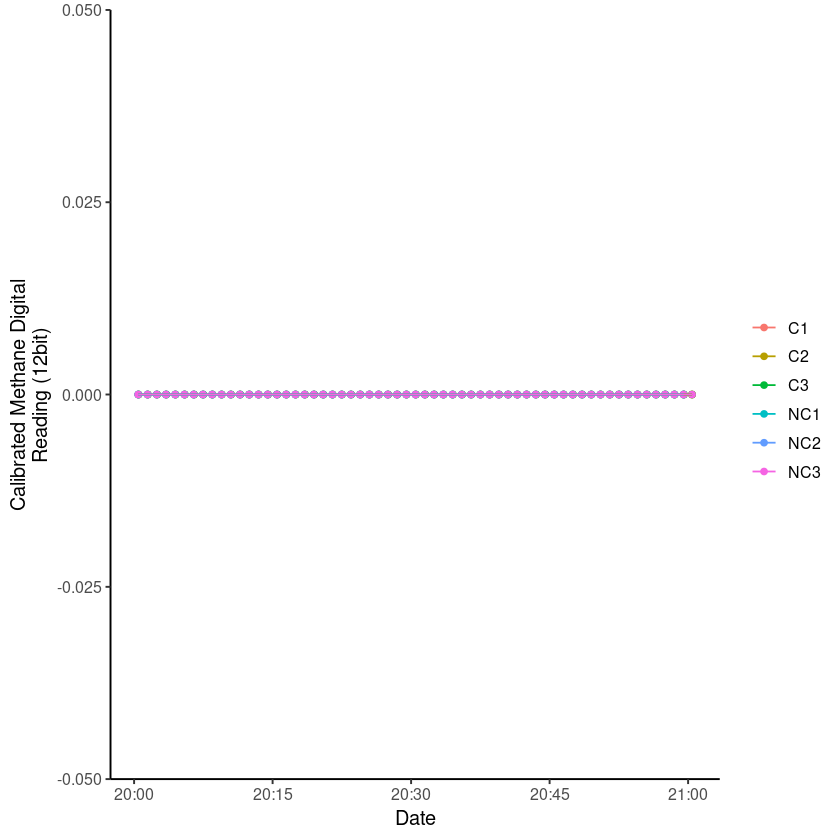

In [19]:
# plot_Data_v_Time(subset_spd,color="site")